In [1]:
from transformers import pipeline
import torch
from transformers import AutoModel, AutoTokenizer, AutoModelForCausalLM
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from scipy.stats import norm
from statistics import mean, variance as var



model = AutoModelForCausalLM.from_pretrained("gpt2", output_attentions=True, output_hidden_states=True)
tokenizer = AutoTokenizer.from_pretrained("gpt2")

# Set pad token (GPT-2 doesn't have one by default)
tokenizer.pad_token = tokenizer.eos_token
model.config.pad_token_id = tokenizer.pad_token_id
model.eval()

X_static = model.get_input_embeddings().weight.detach().cpu().numpy()
vocab = [tokenizer.decode([i]) for i in range(len(tokenizer))]

C:\Users\lucaf\anaconda3\ancaonda_3\Lib\site-packages\transformers\generation\configuration_utils.py:820: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_attentions` is. When `return_dict_in_generate` is not `True`, `output_attentions` is ignored.
  warnings.warn(
C:\Users\lucaf\anaconda3\ancaonda_3\Lib\site-packages\transformers\generation\configuration_utils.py:820: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_hidden_states` is. When `return_dict_in_generate` is not `True`, `output_hidden_states` is ignored.
  warnings.warn(


In [2]:

def inp(prompt, max_tokens):  # You can set any default max_tokens you want
    inputs = tokenizer(
        prompt,
        return_tensors="pt",
        max_length=max_tokens,
        truncation=True  # This ensures it is cut off if too long
    )
    input_ids = inputs["input_ids"]

    with torch.no_grad():
        output = model(input_ids, use_cache=True, output_hidden_states=True)

    key_values = output.past_key_values  # (batch, heads, sequence, head_dim)
    hidden_states = output.hidden_states

    return hidden_states


In [3]:
def Gram(H_0, H_1, plot_gram):
   
    H_0 = H_0 - H_0.mean(dim=0, keepdim=True)
    H_1 = H_1 - H_1.mean(dim=0, keepdim=True)
    
    gram_matrix = H_0 @ H_1.T
    
#    mean = torch.mean(G, dim=0, keepdim=True)
#    gram_matrix = ( G - mean) #/(G.shape[0]-1)
    
    if plot_gram:
        
        mask = np.zeros_like(gram_matrix.cpu().numpy(), dtype=bool)
        mask[:, 0] = True
        mask[0, :] = True
        
        sns.heatmap(Gram_matrix, cmap="viridis", mask=mask, vmin=-1000, vmax=1000)
        plt.title(f"Layer {layer} Gram Matrix")
        plt.show()
    
    return gram_matrix


def Gram_2(H_0, H_1):
   
    H_0 = H_0 - H_0.mean(dim=0, keepdim=True)
    H_1 = H_1 - H_1.mean(dim=0, keepdim=True)
    
    gram_matrix = H_0.T @ H_1

    return gram_matrix 
    
def principle_angle(G):

        _, S, _ = torch.linalg.svd(G, full_matrices=False)
        angles = torch.rad2deg(torch.arccos(torch.clamp(S, -1.0, 1.0)))
    
        return (angles,S)



In [4]:
def analyze_layer_svd_mp(activations, layer_indices=None, cumulative_threshold=0.9, title_prefix="LN1"):
    """
    Perform SVD, plot scree + cumulative variance, and compare to Marčenko–Pastur bounds for selected layers.
    
    Args:
        activations (List[Tensor]): List of layer outputs, one per layer.
        layer_indices (List[int]): Indices of layers to analyze. If None, analyze all.
        cumulative_threshold (float): Threshold for cumulative explained variance line.
        title_prefix (str): For plot titles.
    """
    if layer_indices is None:
        layer_indices = range(len(activations))

    n = len(layer_indices)
    fig, axes = plt.subplots(n, 3, figsize=(16, 4 * n), squeeze=False)

    for i, layer_idx in enumerate(layer_indices):
        X = activations[layer_idx][0].cpu().numpy()  # shape: [seq_len, hidden_dim]
        X_centered = X - X.mean(axis=0)
        U, S, VT = np.linalg.svd(X_centered, full_matrices=False)
        
        # Explained variance
        eigenvalues = (S ** 2) / X.shape[0]
        variance_ratios = eigenvalues / eigenvalues.sum()
        cumulative = np.cumsum(variance_ratios)

        # MP bounds
        n_samples, n_features = X.shape
        Q = n_samples / n_features
        sigma2 = np.var(X_centered)
        lambda_min = sigma2 * (1 - np.sqrt(1/Q))**2
        lambda_max = sigma2 * (1 + np.sqrt(1/Q))**2
        signal_count = np.sum(eigenvalues > lambda_max)

        # Scree plot
        ax1 = axes[i][0]
        ax1.plot(variance_ratios, marker='o')
        ax1.set_title(f"{title_prefix} Layer {layer_idx} - Scree")
        ax1.set_xlabel("PC Index")
        ax1.set_ylabel("Variance Ratio")
        ax1.grid(True)

        # Cumulative plot
        ax2 = axes[i][1]
        ax2.plot(cumulative, marker='o', color='green')
        ax2.axhline(y=cumulative_threshold, color='r', linestyle='--', label=f'{int(cumulative_threshold*100)}% threshold')
        ax2.set_title(f"{title_prefix} Layer {layer_idx} - Cumulative")
        ax2.set_xlabel("PC Index")
        ax2.set_ylabel("Cumulative Variance")
        ax2.set_ylim([0, 1.05])
        ax2.grid(True)
        ax2.legend()

        # Eigenvalue vs MP bounds
        ax3 = axes[i][2]
        ax3.plot(eigenvalues, marker='o', label="Eigenvalues")
        ax3.axhline(lambda_max, color='r', linestyle='--', label=f'MP Upper: {lambda_max:.4f}')
        ax3.axhline(lambda_min, color='gray', linestyle='--', label=f'MP Lower: {lambda_min:.4f}')
        ax3.set_title(f"{title_prefix} Layer {layer_idx} - MP Test\nSignal dims: {signal_count}")
        ax3.set_xlabel("Index")
        ax3.set_ylabel("Eigenvalue")
        ax3.grid(True)
        ax3.legend()

    plt.tight_layout()
    plt.show()



In [5]:


def Q_work(Q):
    Q = np.asarray(Q)
    mu = np.mean(Q)
    sigma = np.std(Q)


    n = 1
    # Define bounds
    lower_bound = mu - n * sigma
    upper_bound = mu + n * sigma

    # Find values more than 2 sigma away
    outliers = Q[(Q < lower_bound) | (Q > upper_bound)]

    # Plot histogram of all data
    plt.hist(Q, bins=20, density=True, color='skyblue', alpha=0.7, label='Data')

    # Plot Gaussian fit
    x = np.linspace(mu - 4*sigma, mu + 4*sigma, 1000)
    y = norm.pdf(x, mu, sigma)
    plt.plot(x, y, 'r-', label='Gaussian PDF')

    # Overlay outliers
    if len(outliers) > 0:
        plt.hist(outliers, bins=20, density=True, color='orange', alpha=0.8, label='> 2σ')

    # Labels and legend
    plt.title('Normal Distribution Fit')
    plt.xlabel('x')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True)
    plt.show()

def first_prompt(dimension, Q_arr_list, eigenvalues_list):
    """
    Plots eigenvalues and Q values for each layer in separate plots.
    `dimension` is assumed to be constant across layers.
    `Q_arr_list` and `eigenvalues_list` are lists of arrays (one per layer).
    """
    n_layers = len(eigenvalues_list)

    for i in range(n_layers):
        eigenvalues = eigenvalues_list[i]
        Q_arr = Q_arr_list[i]


        plt.figure(figsize=(12, 4))

        # Plot 1: Eigenvalues
        plt.subplot(1, 2, 1)
        plt.plot(np.arange(1,len(eigenvalues)+1), eigenvalues, marker='o', label=f"Layer {i}")
        plt.title(f"Eigenvalues - Layer {i}")
        plt.xlabel("Index")
        plt.ylabel("Eigenvalue")
        plt.grid(True)

        # Plot 2: Q values
        plt.subplot(1, 2, 2)
        plt.plot(np.arange(1,len(Q_arr)+1), Q_arr, marker='s', label=f"Layer {i}", color='orange')
        plt.title(f"Q values - Layer {i}")
        plt.xlabel("Index")
        plt.ylabel("Q")
        plt.grid(True)

        plt.suptitle(f"Layer {i}")
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()


    plt.figure(figsize=(8, 5))
    x_dim = np.arange(len(dimension))
    plt.plot(x_dim, dimension, linestyle='--', color='red', marker='o', label='Dimension')

    # Annotate each point with its value
    for x, y in zip(x_dim, dimension):
        plt.text(x, y + max(dimension)*0.02, f"{y}", ha='center', fontsize=9, color='darkred')

    plt.title("Model Dimension Across Layers", fontsize=13)
    plt.xlabel("Layer Index", fontsize=11)
    plt.ylabel("Dimension", fontsize=11)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


def dimension_compute(eigenvalues, X):
    Q_arr=[]
          
    for i in range(len(eigenvalues)-2):
        Q=(eigenvalues[i]-eigenvalues[i+1])/(eigenvalues[i+1]-eigenvalues[i+2])

        Q_arr.append(Q)
        
    Q_max=max(Q_arr)
    
    if Q_max>250:  #very big limit
        d = np.argmax(Q_arr) + 2
              
    else: 
        X_centered = X - X.mean(axis=0)
        n_samples, n_features = X.shape
        Q = n_samples / n_features
        sigma = torch.var(X_centered, unbiased=False).item()
        
        lambda_max = sigma * (1 + np.sqrt(1/Q))**2
        d = np.sum(eigenvalues > lambda_max)

    return(d, Q_arr)


In [6]:
def get_signal_dimensions(activations):
    """
    Returns a list of signal subspace dimensions per layer using MP bound.
    """
    signal_dims = []

    for layer_out in activations:
        X = layer_out[0].cpu().numpy()  # [seq_len, hidden_dim]
        X_centered = X - X.mean(axis=0)
        U, S, VT = np.linalg.svd(X_centered, full_matrices=False)
        eigenvalues = (S ** 2) / X.shape[0]

        n_samples, n_features = X.shape
        Q = n_samples / n_features
        sigma2 = np.var(X_centered)

        lambda_max = sigma2 * (1 + np.sqrt(1/Q))**2
        d = np.sum(eigenvalues > lambda_max)
        signal_dims.append(d)

    return signal_dims



def compute_P_angle(prompt, max_token):
    pAngle_all = []
    dist_all=[]
    rows=[]
    Q_plot=False

    for n,i in enumerate(prompt):
    
      #  hidden_states= embedding(i)  #if u want to analyze before attention mechanism
        hidden_states= inp(i, max_token)
        
        plot_gram=False
        U_list=[]
        dimension=[]
        Q_tot=[]
        eight_tot =[]

        print("Done the prompt: ",n)


        for layer in range(len(hidden_states)):
    
            gram_matrix = Gram(hidden_states[layer][0], hidden_states[layer][0], plot_gram)

        ####################################### defining d ######################
    
            eigenvalues, _ = torch.linalg.eigh(gram_matrix)
            eigenvalues=np.sort(eigenvalues)[::-1]

            eight_tot.append(eigenvalues)

            d, Q_arr = dimension_compute(eigenvalues, hidden_states[layer][0])

            dimension.append(d)
            Q_tot.append(Q_arr)
      
            U, _, _ = torch.svd(gram_matrix)

            U_d = U[:, :d]    
            U_list.append(U_d)

            p_Angle=[]
            dist = []


        for i in range(len(U_list)):
            temp_2=[]
            temp_1=[]
            
            for j in range(len(U_list)):
    
                G_sup=Gram_2(U_list[i], U_list[j])
                angles, S= principle_angle(G_sup)        
               
                temp_2.append((angles.sum().item())/(len(angles)*90))
                temp_1.append(torch.norm(angles).item())

            p_Angle.append(temp_2)
            dist.append(temp_1)

        pAngle_all.append(np.array(p_Angle))
        dist_all.append(np.array(dist))

        if n==0:
           first_prompt(dimension, Q_tot, eight_tot)
           analyze_layer_svd_mp(hidden_states, layer_indices=[0, 6, 12], title_prefix="LN1")

    return(pAngle_all,  dist_all, Q_tot)
        



In [7]:
def plot_principle_angle(pAngle_all,dist_all, Q_tot):
    pAngle_all = np.stack(pAngle_all)  # (num_prompts, num_layers, num_layers)
    dist_all = np.stack(dist_all)
    heat_mean = pAngle_all.mean(axis=0)  # (num_layers, num_layers)
    heat_mean_dist = dist_all.mean(axis=0)

    # Maschera diagonale
    mask_diag = np.eye(heat_mean.shape[0], dtype=bool)

    # Heatmap angoli principali
    plt.figure(figsize=(8, 7))
    sns.heatmap(heat_mean, cmap="coolwarm", fmt=".3f", annot=True, mask=mask_diag,
                    square=True, linewidths=0.5, cbar_kws={'label': 'Angle (deg)'})
    
    plt.title("Mean Principal Angles Between Layers")
    plt.xlabel("Layer")
    plt.ylabel("Layer")
    plt.tight_layout()
    plt.show()

    # Heatmap distanze
    plt.figure(figsize=(8, 7))
    sns.heatmap(heat_mean_dist, cmap="coolwarm", fmt=".3f", annot=True, mask=mask_diag,
                    square=True, linewidths=0.5, cbar_kws={'label': 'Distance'})
    plt.title("Mean Distance Between Layers ")
    plt.xlabel("Layer")
    plt.ylabel("Layer")
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(14, 5))
    plt.title("Principal Angle")

    x1 = np.arange(len(heat_mean[:, 0]))
    y1 = heat_mean[:, 0]
    plt.plot(x1, y1, label="Vs First", marker='o')

    # Aggiungi valori come testo sopra i punti "Vs First"

    ymin, ymax = plt.ylim()
    offset = (ymax - ymin) * 0.02  # 2% of the y-axis range

    for i, (x, y) in enumerate(zip(x1, y1)):
        plt.text(x, y + offset, f"{y:.3f}", ha='center', fontsize=9, color="blue")

    diag = np.diagonal(heat_mean, offset=-1)
    x2 = np.arange(len(diag))
    y2 = diag
    plt.plot(x2, y2, label="Vs Previous", marker='o',color="orange")

    # Aggiungi valori come testo sopra i punti "Vs Previous"
    for i, (x, y) in enumerate(zip(x2, y2)):
        plt.text(x, y+  offset , f"{y:.3f}", ha='center', fontsize=9,color="red")

    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.xlabel("Layer index")
    plt.ylabel("Mean Principal Angle")
    plt.show()
    
    ##############################################################

   # for q in Q_tot:
       # Q_work(q)
    

In [8]:
#PROMPT TAKEN FROM "Harry-Potter-and-the-Philosophers-Stone" by J.K. Rowling

prompt=["Titles available in the Harry Potter series (in reading order): Harry Potter and the Philosopher’s Stone Harry Potter and the Chamber of Secrets Harry Potter and the Prisoner of Azkaban Harry Potter and the Goblet of Fire Harry Potter and the Order of the Phoenix Harry Potter and the Half-Blood Prince Harry Potter and the Deathly Hallows Titles available in the Harry Potter series (in Latin): Harry Potter and the Philosopher’s Stone Harry Potter and the Chamber of Secrets (in Welsh, Ancient Greek and Irish): Harry Potter and the Philosopher’s Stone Harry Potter and the Philosopher’s Stone J. K. Rowling All rights reserved; no part of this publication may be reproduced or transmitted by any means, electronic, mechanical, photocopying or otherwise, withou t the prior permission of the publisher First published in Great Britain in 1997 Bloomsbury Publishing Plc, 36 Soho Square, London, W1D 3QY This edition first published in 2004 Copyright © 1997 J. K. Rowling Harry Potter, names, characters and related indicia are copyright and trademar k Warner Bros., 2000™ The moral right of the author has been asserted A CIP catalogue record of this book is available from th e British Library ISBN 978 0 7475 7360 9 The paper this book is pr inted on is certified by the © 1996 Forest Stewardship Council A.C. (FSC). It is ancient- forest friendly. The printer holds FSC chain of custody SGS-COC-2061. © FSC Mixed Sources Product group from well-managed forests and other controlled sources Cert no. SGS-COC-2061 www.fsc.org ©1996 Forest Stewardship Council Printed in Great Britain by Clays Ltd, St Ives plc Typeset by Dorchester Typesetting 5 7 9 10 8 6 4 www.bloomsbury.com/harrypotter for Jessica, who loves stories, for Anne, who loved them too, and for Di, who heard this one first. — CHAPTER ONE — The Boy Who Lived Mr and Mrs Dursley , of number four, Privet Drive, were proud to say that they were perfectly normal, thank you very much. They were the last people you’d expect to be involved in anything strange or mysterious, because they just didn’t hold with such nonsense. Mr Dursley was the director of a firm called Grunnings, which made drills. He was a big, beef y man with hardly any neck, although he did have a very large moustache. Mrs Dursley was thin and blonde and had nearly twice the usual amount of neck, which came in very useful as she spent so much of her time craning over garden fences, spying on the neighbours. The Dursleys had a small son called Dudley and in their opinion there was no finer boy anywhere. The Dursleys had everything they wanted, but they also had a secret, and their greatest fear wa s that somebody would discover it. They didn’t think they could bear it if anyone found out about the Potters. Mrs Potter was Mrs Dursley’s sister, but they hadn’t met for several years; in fact, Mrs Dursley pretended she didn’t have a sister, because her sister and her",
"good-for-nothing husband were as unDursleyish as it was possible to be. The Dursleys shuddered to think what the neighbours would say if the Potters arrived in the street. The Dursleys knew that the Potters had a small son, too, but they had never even seen him. This boy was another good reason for keeping the Potters away; they didn’t want Dudley mixing with a child like that. When Mr and Mrs Dursley woke up on the dull, grey T uesday our story starts, there was nothing about the cloudy sky outside to suggest that strange and mysterious things would soon be hap-pening all over the country . Mr Dursley hummed as he picked out his most boring tie for work and Mrs Dursley gossiped away 8 H ARRY POTTER happily as she wrestled a screaming Dudley into his high chair. None of them noticed a large ta wny owl flutter past the window. At half past eight, Mr Dursley picked up his briefcase, pecked Mrs Dursley on the cheek and tried to kiss Dudley goodbye but missed, because Dudley was now having a tantrum and throwing his cereal at the walls. ‘Little tyke,’ chortled Mr Dursley as he left the house. He got into his car and backed out of number four’s drive. It was on the corner of the street that he noticed the first sign of something peculiar – a cat reading a map. For a second, Mr Dursley didn’t realise what he had seen – then he jerked his head around to look again. There was a tabby cat standing on the corner of Privet Drive, but there wasn’t a map in sight. What could he have been thinking of? It must have been a trick of the light. Mr Dursley blinked and stared at the cat. It stared back. As Mr Dursley drove around the corner and up the road, he watched the cat in his mirror. It was now reading the sign that said Privet Drive – no, looking at the sign; cats couldn’t read maps or signs. Mr Dursley gave himself a little shake and put the cat out of his mind. As he drove towards town he thought of nothing except a large order of drills he was hoping to get that day . But on the edge of town, drills were driven out of his mind by something else. As he sat in the usual morning traffic jam, he couldn’t help noticing that there seemed to be a lot of strangely dressed people about. People in cloaks. Mr Dursley couldn’t bear people who dressed in funny clothes – the get-ups you saw on young people! He supposed this was some stupid new fashion. He drummed his fingers on the steering wheel and his eyes fell on a huddle of these weirdos standing quite close by . They were whis-pering excitedly together. Mr Dursley was enraged to see that a couple of them weren’t young at a ll; why , that man had"

"to be older than he was, and wearing an emerald-green cloak! The nerve of him! But then it struck Mr Durs ley that this was probably some silly stunt – these people were obviously collecting for something ... yes, that would be it. The traffic moved on, and a few minutes later, Mr Dursley arrived in the Grunnings car park, his mind back on drills. Mr Dursley always sat with his back to the window in his office on the ninth floor. If he hadn’t, he might have found it harder to concentrate on drills that morning. He didn’t see the owls T HE BOY WHO LIVED 9 swooping past in broad daylight, though people down in the street did; they pointed and gazed open-mouthed as owl after owl sped overhead. Most of them had never seen an owl even at night-time. Mr Dursley , however, had a perfectly normal, owl-free morn-ing. He yelled at five different people. He made several important telephone calls and shouted a bit more. He was in a very good mood until lunch-time, when he thought he’d stretch his legs and walk across the road to buy himself a bun from the baker’s opposite. He’d forgotten all about the peop le in cloaks until he passed a group of them next to the baker’s. He eyed them angrily as he passed. He didn’t know why , but they made him uneasy . This lot were whispering excitedly , too, and he couldn’t see a single collecting tin. It was on his way back past them, clutching a large doughnut in a bag, that he caught a few words of what they were saying. ‘The Potters, that’s right, that’s what I heard –’ ‘– yes, their son, Harry –’ Mr Dursley stopped dead. Fear flooded him. He looked back at the whisperers as if he wanted to say something to them, but thought better of it. He dashed back across the road, hurried up to his office, snapped at his secretary not to disturb him, seized his telephone and had almost finished dialling his home number when he changed his mind. He put the receiver back down and stroked his moustache, thinking ... no, he wa s being stupid. Potter wasn’t such an unusual name. He was sure there were lots of people called Potter who had a son called Harry . Come to think of it, he wasn’t even sure his nephew was called Harry . He’d never even seen the boy . It might have been Harvey . Or Harold. There was no point in worrying Mrs Dursley , she always got so upset at any mention of her sister. He didn’t blame her – if he’d had a sister like that ... but all the same, those people in cloaks ... He found it a lot harder to concentrate on drills that afternoon, and when he left the building at five o’clock, he was still so worried that he walked straight into someone",

"just outside the door. ‘Sorry ,’ he grunted, as the tiny old man stumbled and almost fell. It was a few seconds before Mr Dursley realised that the man was wearing a violet cloak. He didn’t seem at all upset at being almost knocked to the ground. On the contrary , his face split into 10 H ARRY POTTER a wide smile and he said in a squeaky voice that made passers-by stare: ‘Don’t be sorry , my dear sir, for nothing could upset me today! Rejoice, for You-Know-Who has gone at last! Even Muggles like yourself should be celebrating, this happy happy day!’ And the old man hugged Mr Dursley around the middle and walked off. Mr Dursley stood rooted to the spot. He had been hugged by a complete stranger. He also thought he had been called a Muggle, whatever that was. He was rattled. He hurried to his car and set off home, hoping he was imagin ing things, which he had never hoped before, because he didn’t approve of imagination. As he pulled into the driveway of number four, the first thing he saw – and it didn’t improve his mood – was the tabby cat he’d spotted that morning. It was now sitting on his garden wall. He was sure it was the same one; it had the same markings around its eyes. ‘Shoo!’ said Mr Dursley loudly . The cat didn’t move. It just gave him a stern look. Was this nor- mal cat behaviour, Mr Dursley wondered. Trying to pull himself together, he let himself into the house. He was still determined not to mention anything to his wife. Mrs Dursley had had a nice, normal day . She told him over din- ner all about Mrs Next Door’s problems with her daughter and how Dudley had learnt a new word (‘Shan’t!’). Mr Dursley tried to act normally . When Dudley had been put to bed, he went into the living-room in time to catch the last report on the evening news: And finally , bird-watchers everywhere have reported that the nation’s owls have been behaving very unusually today . Although owls normally hunt at night and are hardly ever seen in daylight, there have been hundreds of sightings of these birds flying in every direction since sunrise. Experts are unable to explain why the owls have suddenly changed their sleeping pattern.’ The news reader allowed himself a grin. ‘Most mysterious. And now , over to Jim McGuffin with the weather. Going to be any more showers of owls tonight, Jim?’ ‘Well, Ted,’ said the weatherman, ‘I don’t know about that, but it’s not only the owls that have been acting oddly today . Viewers as far apart as Kent, Yorkshire and Dundee have been phoning in to tell me that instead of the rain I promised yesterday , they’ve had a downpour of shooting stars! Perhaps people have been T HE BOY WHO LIVED 11 celebrating Bonfire Night early – it’s not"

"until next week, folks! But I can promise a wet night tonight.’ Mr Dursley sat frozen in his armchair. Shooting stars all over Britain? Owls flying by daylight? Mysterious people in cloaks all over the place? And a whisper, a whisper about the Potters ... Mrs Dursley came into the living-room carrying two cups of tea. It was no good. He’d have to say something to her. He cleared his throat nervously . ‘Er – Petunia, dear – you haven’t heard from your sister lately , have you?’ As he had expected, Mrs Dursley looked shocked and angry . After all, they normally pretended she didn’t have a sister. ‘No,’ she said sharply . ‘Why?’ ‘Funny stuff on the news,’ Mr Dursley mumbled. ‘Owls ... shooting stars ... and there were a lot of funny-looking people in town today ...’ ‘So?’ snapped Mrs Dursley . ‘Well, I just thought ... maybe ... it was something to do with ... you know ... her lot.’ Mrs Dursley sipped her tea through pursed lips. Mr Dursley wondered whether he dared tell he r he’d heard the name ‘Potter’. He decided he didn’t dare. Instead he said, as casually as he could, ‘Their son – he’d be about Dudley’s age now , wouldn’t he?’ ‘I suppose so,’ said Mrs Dursley stiffly . ‘What’s his name again? Howard, isn’t it?’ ‘Harry . Nasty , common name, if you ask me.’ ‘Oh, yes,’ said Mr Dursley , his heart sinking horribly . ‘Yes, I quite agree.’ He didn’t say another word on the subject as they went upstairs to bed. While Mrs Dursley was in the bathroom, Mr Dursley crept to the bedroom window and peered down into the front garden. The cat was still there. It was star ing down Privet Drive as though it was waiting for something. Was he imagining things? Could all this have anything to do with the Potters? If it did ... if it got out that they were related to a pair of – well, he didn’t think he could bear it. The Dursleys got into bed. Mrs Dursley fell asleep quickly but Mr Dursley lay awake, turning it all over in his mind. His last, comforting thought before he fell asleep was that even if the Potters were involved, there was no reason for them to come near him and Mrs Dursley . The Potters knew very well what he and 12 H ARRY POTTER Petunia thought about them and their kind ... He couldn’t see how he and Petunia could get mixed up in anything that might be going on. He yawned and turned over. It couldn’t affect them ... How very wrong he was. Mr Dursley might have been drifting into an uneasy sleep, but the cat on the wall outside was showing no sign of sleepiness. It was sitting as still as a statue, its eyes fixed unblinkingly on the far corner of Privet Drive. It didn’t so much as quiver when a car",
        
"door slammed in the next street, nor when two owls swooped overhead. In fact, it was nearly midnight before the cat moved at all. A man appeared on the corner the cat had been watching, appeared so suddenly and silently you’d have thought he’d just popped out of the ground. The cat’s tail twitched and its eyes narrowed. Nothing like this man had ever been seen in Privet Drive. He was tall, thin and very old, judging by the silver of his hair and beard, which were both long enough to tuck into his belt. He was wearing long robes, a purple cloak which swept the ground and high-heeled, buckled boots. His blue eyes were light, bright and sparkling behind half-moon spectacl es and his nose was very long and crooked, as though it had been broken at least twice. This man’s name was Albus Dumbledore. Albus Dumbledore didn’t seem to realise that he had just arrived in a street where everything from his name to his boots was unwelcome. He was busy rummaging in his cloak, looking for something. But he did seem to realise he was being watched, because he looked up suddenly at the cat, which was still staring at him from the other end of the street. For some reason, the sight of the cat seemed to amuse him. He chuckled and muttered, ‘I should have known.’ He had found what he was looking for in his inside pocket. It seemed to be a silver cigarette lighter. He flicked it open, held it up in the air and clicked it. The nearest street lamp went out with a little pop. He clicked it again – the next lamp flickered into darkness. T welve times he clic ked the Put-Outer, until the only lights left in the whole street were two tiny pinpricks in the dis- tance, which were the eyes of the cat watching him. If anyone looked out of their window now , even beady-eyed Mrs Dursley , they wouldn’t be able to see an ything that was happening down on the pavement. Dumbledore slipped the Put-Outer back inside T HE BOY WHO LIVED 13 his cloak and set off down the street towards number four, where he sat down on the wall next to the cat. He didn’t look at it, but after a moment he spoke to it. ‘Fancy seeing you here, Professor McGonagall.’ He turned to smile at the tabby , but it had gone. Instead he was smiling at a rather severe-looking woman who was wearing square glasses exactly the shape of the markings the cat had had around its eyes. She, too, was wearing a cloak, an emerald one. Her black hair was drawn into a tight bun. She looked distinctly ruffled. ‘How did you know it was me?’ she asked. ‘My dear Professor, I’ve never seen a cat sit so stiffly .’ ‘You’d be stiff if you’d been sitting on a brick wall all day ,’ said Professor McGonagall.",
"‘All day? When you could have been celebrating? I must have passed a dozen feasts and parties on my way here.’ Professor McGonagall sniffed angrily . ‘Oh yes, everyone’s celebrating, all right,’ she said impatiently . ‘You’d think they’d be a bit more careful, but no – even the Muggles have noticed something’s going on. It was on their news.’ She jerked her head back at the Dursleys’ dark living-room window. ‘I heard it. Flocks of owls ... shooting stars ... Well, they’re not completely stupid. They were bound to notice something. Shooting stars down in Kent – I’ll bet that was Dedalus Diggle. He never had much sense.’ ‘You can’t blame them,’ said Dumbledore gently . ‘We’ve had precious little to celebrate for eleven years.’ ‘I know that,’ said Professor McGo nagall irritably . ‘But that’s no reason to lose our heads. People are being downright careless, out on the streets in broad daylight, not even dressed in Muggle clothes, swapping rumours.’ She threw a sharp, sideways glance at Dumbledore here, as though hoping he was going to tell her something, but he didn’t, so she went on: ‘A fine thing it would be if, on the very day Y ou-Know-Who seems to have disappeared at last, the Muggles found out about us all. I suppose he really has gone, Dumbledore?’ ‘It certainly seems so,’ said Dumbledore. ‘We have much to be thankful for. Would you care for a sherbet lemon?’ ‘A what ?’ ‘A sherbet lemon. They’re a kind of Muggle sweet I’m rather fond of.’ 14 H ARRY POTTER ‘No, thank you,’ said Professo r McGonagall coldly , as though she didn’t think this was the moment for sherbet lemons. ‘As I say , even if You-Know-Who has gone –’ ‘My dear Professor, surely a sensible person like yourself can call him by his name? All this “You-Know-Who” nonsense – for eleven years I have been trying to persuade people to call him by his proper name: Voldemort .’ Professor McGonagall flinched, but Dumbledore, who was unsticking two sherbet lemons, seemed not to notice. ‘It all gets so co nfusing if we keep saying “You- Know-Who”.’ I have never seen any reason to be frightened of saying Voldemort’s name.’ ‘I know you haven’t,’ said Prof essor McGonagall, sounding half- exasperated, half-admiring. ‘But you’re different. Everyone knows you’re the only one You-Know – oh, all right, Voldemort – was frightened of.’ ‘You flatter me,’ said Dumbledore calmly . ‘Voldemort had powers I will never have.’ ‘Only because you’re too – well – noble to use them.’ ‘It’s lucky it’s dark. I haven’ t blushed so much since Madam Pomfrey told me she liked my new earmuffs.’ Professor McGonagall shot a sharp look at Dumbledore and said, ‘The owls are nothing to the rumours that are flying around. You know what everyone’s saying? About why he’s disappeared? About what finally stopped him?’ It seemed that Professor McGonagall had reached the point she was most anxious to discuss, the real",

"reason she had been waiting on a cold hard wall all day , for neither as a cat nor as a woman had she fixed Dumbledore with such a piercing stare as she did now. It was plain that whatever ‘everyone’ was saying, she was not going to believe it until Dumbledore told her it was true. Dumbledore, however, was choosing another sherbet lemon and did not answer. ‘What they’re saying,’ she pressed on, ‘is that last night Voldemort turned up in Godric’s Hollow. He went to find the Potters. The rumour is that Lily and James Potter are – are – that they’re – dead. ’ Dumbledore bowed his head. Pr ofessor McGonagall gasped. ‘Lily and James ... I can’t believe it ... I didn’t want to believe it ... Oh, Albus ...’ Dumbledore reached out and patted her on the shoulder. ‘I T HE BOY WHO LIVED 15 know ... I know ...’ he said heavily . Professor McGonagall’s voice trembled as she went on. ‘That’s not all. They’re saying he tried to kill the Potters’ son, Harry . But – he couldn’t. He couldn’t kill that little boy . No one knows why , or how , but they’re saying that when he couldn’t kill Harry Potter, Voldemort’s power somehow broke – and that’s why he’s gone.’ Dumbledore nodded glumly . ‘It’s – it’s true?’ faltered Professor McGonagall. ‘After all he’s done ... all the people he’s killed ... he couldn’t kill a little boy? It’s just astounding ... of all the things to stop him ... but how in the name of heaven did Harry survive?’ ‘We can only guess,’ said Dumbledore. ‘We may never know.’ Professor McGonagall pulled out a lace handkerchief and dabbed at her eyes beneath her spectacles. Dumbledore gave a great sniff as he took a golden watch from his pocket and examined it. It was a very odd watch. It had twelve hands but no numbers; instead, little planets were moving around the edge. It must have made sense to Dumbledore, though, because he put it back in his pocket and said, ‘Hagrid’s late. I suppose it was he who told you I’d be here, by the way?’ ‘Yes,’ said Professor McGonagall. ‘And I don’t suppose you’re going to tell me why you’re here, of all places?’ ‘I’ve come to bring Harry to his aunt and uncle. They’re the only family he has left now.’ ‘You don’t mean – you can’t mean the people who live here?’ cried Professor McGonagall, jumpin g to her feet and pointing at number four. ‘Dumbledore – you can’t. I’ve been watching them all day . You couldn’t find two people who are less like us. And they’ve got this son – I saw him kicking his mother all the way up the street, screaming for sweets. Harry Potter come and live here!’ ‘It’s the best place for him,’ said Dumbledore firmly . ‘His aunt and uncle will be able to explain everything to him when",

"he’s older. I’ve written them a letter.’ ‘A letter?’ repeated Professor Mc Gonagall faintly , sitting back down on the wall. ‘Really , Dumbledore, you think you can explain all this in a letter? These people will never understand him! He’ll be famous – a legend – I wouldn’t be surprised if today was known as Harry Potter Day in future – there will be books written about Harry – every child in our world will know his name!’ ‘Exactly ,’ said Dumbledore, looking very seriously over the top 16 H ARRY POTTER of his half-moon glasses. ‘It would be enough to turn any boy’s head. Famous before he can walk and talk! Famous for something he won’t even remember! Can’t you see how much better off he’ll be, growing up away from all that until he’s ready to take it?’ Professor McGonagall opened her mouth, changed her mind, swallowed and then said, ‘Yes – yes, you’re right, of course. But how is the boy getting here, Dumbledore?’ She eyed his cloak suddenly as though she thought he might be hiding Harry underneath it. ‘Hagrid’s bringing him.’ ‘You think it – wise – to trust Hagrid with something as impor- tant as this?’ ‘I would trust Hagrid with my life,’ said Dumbledore. ‘I’m not saying his heart isn’t in the right place,’ said Professor McGonagall grudgingly , ‘but you can’t pretend he’s not careless. He does tend to – what was that?’ A low rumbling sound had broken the silence around them. It grew steadily louder as they looked up and down the street for some sign of a headlight; it swelled to a roar as they both looked up at the sky – and a huge motorbike fell out of the air and landed on the road in front of them. If the motorbike was huge, it was nothing to the man sitting astride it. He was almost twice as tall as a normal man and at least five times as wide. He looked simply too big to be allowed, and so wild – long tangles of bushy black hair and beard hid most of his face, he had hands the size of dustbin lids and his feet in their leather boots were like baby dolphi ns. In his vast, muscular arms he was holding a bundle of blankets. ‘Hagrid,’ said Dumbledore, sounding relieved. ‘At last. And where did you get that motorbike?’ ‘Borrowed it, Professor Dumbledore, sir,’ said the giant, climbing carefully off the motorbike as he spoke. ‘Young Sirius Black lent it me. I’ve got him, sir.’ ‘No problems, were there?’ ‘No, sir – house was almost destroyed but I got him out all right before the Muggles started swarmin’ around. He fell asleep as we was flyin’ over Bristol.’ Dumbledore and Professor McGonagall bent forward over the bundle of blankets. Inside, just visible, was a baby boy , fast asleep. Under a tuft of jet-black hair over his forehead they could see a T HE BOY",

"WHO LIVED 17 curiously shaped cut, like a bolt of lightning. ‘Is that where –?’ whispered Professor McGonagall. ‘Yes,’ said Dumbledore. ‘He’ll have that scar for ever.’ ‘Couldn’t you do something about it, Dumbledore?’ ‘Even if I could, I wouldn’t. Scars can come in useful. I have one myself above my left knee which is a perfect map of the London Underground. Well – give him here, Hagrid – we’d better get this over with.’ Dumbledore took Harry in his arms and turned towards the Dursleys’ house. ‘Could I – could I say goodbye to him, sir?’ asked Hagrid. He bent his great, shaggy head over Harry and gave him what must have been a very scratchy , whiskery kiss. Then, suddenly , Hagrid let out a howl like a wounded dog. ‘Shhh!’ hissed Professor McGonaga ll. ‘You’ll wake the Muggles!’ ‘S-s-sorry ,’ sobbed Hagrid, taking out a large spotted handker- chief and burying his face in it. ‘But I c-c-can’t stand it – Lily an’ James dead – an’ poor little Harry off ter live with Muggles –’ ‘Yes, yes, it’s all very sad, but get a grip on yourself, Hagrid, or we’ll be found,’ Professor McGonagall whispered, patting Hagrid gingerly on the arm as Dumbledore stepped over the low garden wall and walked to the front door. He laid Harry gently on the doorstep, took a letter out of his cloak, tucked it inside Harry’s blankets and then came back to the other two. For a full minute the three of them stood and looked at the little bundle; Hagrid’s shoulders shook, Professor McGonagall blinked furiously and the twinkling light that usually shone from Dumbledore’s eyes seemed to have gone out. ‘Well,’ said Dumbledore finally , ‘that’s that. We’ve no business staying here. We may as well go and join the celebrations.’ ‘Yeah,’ said Hagrid in a very muffled voice. ‘I’d best get this bike away . G’night, Professor McGonagall – Professor Dumbledore, sir.’ Wiping his streaming eyes on his jacket sleeve, Hagrid swung himself on to the motorbike and ki cked the engine into life; with a roar it rose into the air and off into the night. ‘I shall see you soon, I expect, Professor McGonagall,’ said Dumbledore, nodding to her. Prof essor McGonagall blew her nose in reply . Dumbledore turned and walked back down the street. On the 18 H ARRY POTTER corner he stopped and took out the silver Put-Outer. He clicked it once and twelve balls of light sped back to their street lamps so that Privet Drive glowed suddenl y orange and he could make out a tabby cat slinking around the corner at the other end of the street. He could just see the bundle of blankets on the step of number four. ‘Good luck, Harry ,’ he murmured. He turned on his heel and with a swish of his cloak he was gone. A breeze ruffled the neat hedges of Privet Drive, which lay silent and tidy under the",

"inky sky , the very last place you would expect astonishing things to happen. Harry Potter rolled over inside his blankets without waking up. One small hand closed on the letter beside him and he slept on, not knowing he was special, not knowing he was famous, not knowing he would be woken in a few hours’ time by Mrs Dursley’s scream as she opened the front door to put out the milk bottles, nor that he would spend the next few weeks being prodded and pinched by his cousin Dudley ... He couldn’t know that at this very moment, people meeting in secret all over the country were holding up their glasses and saying in hushed voices: ‘To Harry Potter – the boy who lived!’ — CHAPTER TWO — The Vanishing Glass Nearly ten years had passed since the Dursleys had woken up to find their nephew on the front step, but Privet Drive had hardly changed at all. The sun rose on the same tidy front gardens and lit up the brass number four on the Dursleys’ front door; it crept into their living-room, which was almost exactly the same as it had been on the night when Mr Dursley had seen that fateful news report about the owls. Only the photographs on the mantelpiece really showed how much time had passed. Ten years ago, there had been lots of pictures of what looked like a large pink beach ball wearing different-coloured bobble hats – but Dudley Dursley was no longer a baby , and now the photographs showed a large, blond boy riding his first bicycle, on a roundabout at the fair, playing a computer game with his father, being hugged and kissed by his mother. The room held no sign at all that another boy lived in the house, too. Yet Harry Potter was still there, asleep at the moment, but not for long. His Aunt Petunia was awake and it was her shrill voice which made the first noise of the day . ‘Up! Get up! Now!’ Harry woke with a start. His aunt rapped on the door again. ‘Up!’ she screeched. Harry heard her walking towards the kitchen and then the sound of the frying pan being put on the cooker. He rolled on to his back and tried to remember the dream he had been having. It had been a good one. There had been a flying motorbike in it. He had a funny feeling he’d had the same dream before. His aunt was back outside the door. ‘Are you up yet?’ she demanded. ‘Nearly ,’ said Harry . ‘Well, get a move on, I want you to look after the bacon. And 20 H ARRY POTTER don’t you dare let it burn, I want everything perfect on Duddy’s birthday .’ Harry groaned. ‘What did you say?’ his aunt snapped through the door. ‘Nothing, nothing ...’ Dudley’s birthday – how could he have forgotten? Harry got slowly out of bed and started looking",

"for socks. He found a pair under his bed and, after pulling a spider off one of them, put them on. Harry was used to spiders, because the cupboard under the stairs was full of them, and that was where he slept. When he was dressed he went do wn the hall into the kitchen. The table was almost hidden beneath all Dudley’s birthday pres-ents. It looked as though Dudley had got the new computer he wanted, not to mention the second television and the racing bike. Exactly why Dudley wanted a racing bike was a mystery to Harry , as Dudley was very fat and hated exercise – unless of course it involved punching somebody . Du dley’s favourite punch-bag was Harry , but he couldn’t often catch him. Harry didn’t look it, but he was very fast. Perhaps it had something to do with living in a dark cupboard, but Harry had always been small and skinny for his age. He looked even smaller and skinnier than he really was because all he had to wear were old clothes of Dudley’s and Dudley was about four times bigger than he was. Harry had a thin face, knobbly knees, black hair and bright-green eyes. He wore round glasses held together with a lot of Se llotape because of all the times Dudley had punched him on the nose. The only thing Harry liked about his own appearance was a very thin scar on his forehead which was shaped like a bolt of lightning. He had had it as long as he could remember and the first question he could ever remember asking his Aunt Petunia was how he had got it. ‘In the car crash when your parents died,’ she had said. ‘And don’t ask questions.’ Don’t ask questions – that was the first ru le for a quiet life with the Dursleys. Uncle Vernon entered the kitchen as Harry was turning over the bacon. ‘Comb your hair!’ he barked, by way of a morning greeting. About once a week, Uncle Vernon looked over the top of his newspaper and shouted that Harry needed a haircut. Harry must T HE VANISHING GLASS 21 have had more haircuts than the rest of the boys in his class put together, but it made no difference, his hair simply grew that way – all over the place. Harry was frying eggs by the time Dudley arrived in the kitchen with his mother. Dudley looked a lot like Uncle Vernon. He had a large, pink face, not much neck, small, watery blue eyes and thick, blond hair that lay smoothly on his thick, fat head. Aunt Petunia often said that Dudley looked like a baby angel – Harry often said that Dudley looked like a pig in a wig. Harry put the plates of egg and bacon on the table, which was difficult as there wasn’t much room. Dudley , meanwhile, was counting his presents. His face fell. ‘Thirty-six,’ he said, looking up",
        
"at his mother and father. ‘That’s two less than last year.’ ‘Darling, you haven’t counted Auntie Marge’s present, see, it’s here under this big one from Mummy and Daddy .’ ‘All right, thirty-seven then,’ sa id Dudley , going red in the face. Harry , who could see a huge Dudley tantrum coming on, began wolfing down his bacon as fast as possible in case Dudley turned the table over. Aunt Petunia obviously scented danger too, because she said quickly , ‘And we’ll buy you another two presents while we’re out today . How’s that, popkin? Tw o more presents. Is that all right?’ Dudley thought for a moment. It looked like hard work. Finally he said slowly , ‘So I’ll have thirty ... thirty ...” ‘Thirty-nine, sweetums,’ said Aunt Petunia. ‘Oh.’ Dudley sat down heavily and grabbed the nearest parcel. All right then.’ Uncle Vernon chuckled. ‘Little tyke wants his money’s worth, just like his father. Atta boy , Dudley!’ He ruffled Dudley’s hair. At that moment the telephone rang and Aunt Petunia went to answer it while Harry and Uncle Vernon watched Dudley unwrap the racing bike, a cine-camera, a remote-control aeroplane, sixteen new computer games and a video recorder. He was ripping the paper off a gold wristwatch when Aunt Petunia came back from the telephone, looking both angry and worried. ‘Bad news, Vernon,’ she said. ‘Mrs Figg’s broken her leg. She can’t take him.’ She jerked her head in Harry’s direction. Dudley’s mouth fell open in horror but Harry’s heart gave a 22 H ARRY POTTER leap. Every year on Dudley’s birthday his parents took him and a friend out for the day , to advent ure parks, hamburger bars or the cinema. Every year, Harry was left behind with Mrs Figg, a mad old lady who lived two streets away . Harry hated it there. The whole house smelled of cabbage and Mrs Figg made him look at photographs of all the cats she’d ever owned. ‘Now what?’ said Aunt Petunia, looking furiously at Harry as though he’d planned this. Harry knew he ought to feel sorry that Mrs Figg had broken her leg, but it wasn’t easy when he reminded himself it would be a whole year before he had to look at Tibbies, Snowy , Mr Paws and T ufty again. ‘We could phone Marge,’ Uncle Vernon suggested. ‘Don’t be silly , Vernon, she hates the boy .’ The Dursleys often spoke about Harry like this, as though he wasn’t there – or rather, as though he was something very nasty that couldn’t understand them, like a slug. ‘What about what’s-her-name, your friend – Yvonne?’ ‘On holiday in Majorca,’ snapped Aunt Petunia. ‘You could just leave me here,’ Harry put in hopefully (he’d be able to watch what he wanted on television for a change and maybe even have a go on Dudley’s computer). Aunt Petunia looked as though she’d just swallowed a lemon. ‘And come back and find the house in ruins?’",
        
"she snarled. ‘I won’t blow up the house,’ said Harry , but they weren’t listening. ‘I suppose we could take him to the zoo,’ said Aunt Petunia slowly , ‘... and leave him in the car ...’ ‘That car’s new , he’s not sitting in it alone ...’ Dudley began to cry loudly . In fa ct, he wasn’t really crying, it had been years since he’d really cried, but he knew that if he screwed up his face and wailed, his mother would give him anything he wanted. ‘Dinky Duddydums, don’t cry , Mummy won’t let him spoil your special day!’ she cried, flinging her arms around him. ‘I ... don’t ... want ... him ... t-t-to come!’ Dudley yelled between huge pretend sobs. ‘He always sp-spoils everything!’ He shot Harry a nasty grin through the gap in his mother’s arms. Just then, the doorbell rang – ‘Oh, Good Lord, they’re here!’ said Aunt Petunia frantically – and a moment later, Dudley’s best friend, Piers Polkiss, walked in with his mother. Piers was a scrawny boy with a face like a rat. He was usually the one who T HE VANISHING GLASS 23 held people’s arms behind thei r backs while Dudley hit them. Dudley stopped pretending to cry at once. Half an hour later, Harry , who couldn’t believe his luck, was sitting in the back of the Dursleys’ car with Piers and Dudley , on the way to the zoo for the first time in his life. His aunt and uncle h a d n ’ t b e e n a b l e t o t h i n k o f a n y t h i n g e l s e t o d o w i t h h i m , b u t before they’d left, Uncle Vernon had taken Harry aside. ‘I’m warning you,’ he had said, putting his large purple face right up close to Harry’s, ‘I’m warning you now , boy – any funny business, anything at all – and yo u’ll be in that cupboard from now until Christmas.’ ‘I’m not going to do anything,’ said Harry , ‘honestly ...’ But Uncle Vernon didn’t believe him. No one ever did. The problem was, strange things often happened around Harry and it was just no good telling the Dursleys he didn’t make them happen. Once, Aunt Petunia, tired of Harry coming back from the bar- ber’s looking as though he hadn’t been at all, had taken a pair of kitchen scissors and cut his hair so short he was almost bald except for his fringe, which she left ‘to hide that horrible scar’. Dudley had laughed himself silly at Harry , who spent a sleepless night imagining school the next day , where he was already laughed at for his baggy clothe s and Sellotaped glasses. Next morning, however, he had got up to find his hair exactly as it had been before Aunt Petunia had",
        
"shear ed it off. He had been given a week in his cupboard for this, even though he had tried to explain that he couldn’t explain how it had grown back so quickly . Another time, Aunt Petunia had been trying to force him into a revolting old jumper of Dudley’s (brown with orange bobbles). The harder she tried to pull it over his head, the smaller it seemed to become, until finally it might have fitted a glove puppet, but certainly wouldn’t fit Harry . Aunt Petunia had decided it must h a v e s h r u n k i n t h e w a s h a n d , t o h i s g r e a t r e l i e f , H a r r y w a s n ’ t punished. On the other hand, he’d got into terrible trouble for being found on the roof of the school kitchens. Dudley’s gang had been chasing him as usual when, as much to Harry’s surprise as anyone else’s, there he was sitting on the chimney . The Dursleys had received a very angry letter from Harry’s headmistress telling them Harry had been climbing school buildings. But all he’d tried to do 24 H ARRY POTTER (as he shouted at Uncle Vernon through the locked door of his cupboard) was jump behind the big bins outside the kitchen doors. Harry supposed that the wind must have caught him in mid-jump. But today , nothing was going to go wrong. It was even worth being with Dudley and Piers to be spending the day somewhere that wasn’t school, his cupboard or Mrs Figg’s cabbage-smelling living-room. While he drove, Uncle Vernon complained to Aunt Petunia. He liked to complain about things: people at work, Harry , the council, Harry , the bank and Harry were just a few of his favourite subjects. This morning, it was motorbikes. ‘... roaring along like maniacs, the young hoodlums,’ he said, as a motorbike overtook them. ‘I had a dream about a motorbike,’ said Harry , remembering suddenly . ‘It was flying.’ Uncle Vernon nearly crashed into the car in front. He turned right around in his seat and yelled at Harry , his face like a gigantic beetroot with a moustache, ‘MOTORBIKES DON’T FLY!’ Dudley and Piers sniggered. ‘I know they don’t,’ said Harry . ‘It was only a dream.’ But he wished he hadn’t said anything. If there was one thing the Dursleys hated even more than his asking questions, it was his talking about anything acting in a way it shouldn’t, no matter if it was in a dream or even a cartoon – they seemed to think he might get dangerous ideas. It was a very sunny Saturday and the zoo was crowded with families. The Dursleys bought Du dley and Piers large chocolate ice-creams at the entrance and then, because the smiling lady in the van had asked Harry what",
  
"with the Dursleys almost ten years, ten miserable years, as long as he could remember, ever since he’d been a baby and his parents had died in that car crash. He couldn’t remember being in the car when his parents had died. Sometimes, when he strained his memory during long hours in his cupboard, he came up with a strange vision: a blinding flash of green light and a burning pain on his forehead. Th is, he supposed, was the crash, though he couldn’t imagine where all the green light came from. He couldn’t remember his parents at all. His aunt and uncle never spoke about them, and of course he was forbidden to ask questions. There were no photographs of them in the house. When he had been younger, Harry had dreamed and dreamed of some unknown relation coming to take him away , but it had never happened; the Dursleys were his only family . Yet sometimes he thought (or maybe hoped) that strangers in the street seemed to know him. Very strange strangers they were, too. A tiny man in a violet top hat had bowed to him once while out shopping with Aunt Petunia and Dudley . After asking Harry furiously if he knew the man, Aunt Petunia had rushed them out of the shop without buying anything. A wild-looking old woman dressed all in green had waved merrily at him once on a bus. A bald man in a very long purple coat had actually shaken his hand in the street the other day and then walked away without a word. The weirdest thing about all these people was the way they seemed to vanish the second Harry tried to get a closer look. At school, Harry had no one. Everybody knew that Dudley’s gang hated that odd Harry Potter in his baggy old clothes and broken glasses, and nobody liked to disagree with Dudley’s gang. — CHAPTER THREE — The Letters from No One The escape of the Brazilian boa constrictor earned Harry his longest-ever punishment. By the time he was allowed out of his cupboard again, the summer holidays had started and Dudley had already broken his new cine-camera, crashed his remote-control aeroplane and, first time on his racing bike, knocked down old Mrs Figg as she crossed Privet Drive on her crutches. Harry was glad school was over, but there was no escaping Dudley’s gang, who visited the house every single day . Piers, Dennis, Malcolm and Gordon were all big and stupid, but as Dudley was the biggest and stupidest of the lot, he was the leader. The rest of them were all quite happy to join in Dudley’s favourite sport: Harry-hunting. This was why Harry spent as much time as possible out of the house, wandering around and thinking about the end of the holi- days, where he could see a tiny ray of hope. When September came he would be going off to secondary school and, for the first",

"time in his life, he wouldn’t be with Dudley . Dudley had a place at Uncle Vernon’s old school, Smeltings. Piers Polkiss was going there, too. Harry , on the other hand, was going to Stonewall High, the local comprehensive. Dudley thought this was very funny . ‘They stuff people’s heads down the toilet first day at Stonewall,’ he told Harry . ‘Want to come upstairs and practise?’ ‘No thanks,’ said Harry . ‘The poor toilet’s never had anything as horrible as your head down it – it might be sick.’ Then he ran, before Dudley could work out what he’d said. One day in July , Aunt Petunia took Dudley to London to buy his Smeltings uniform, leaving Ha rry at Mrs Figg’s. Mrs Figg wasn’t as bad as usual. It turned out she’d broken her leg tripping over one of her cats and she didn’t seem quite as fond of them as before. She let Harry watch te levision and gave him a bit of T HE LETTERS FROM NO ONE 29 chocolate cake that tasted as though she’d had it for several years. That evening, Dudley paraded around the living-room for the family in his brand-new uniform. Smeltings boys wore maroon tailcoats, orange knickerbockers an d flat straw hats called boaters. They also carried knobbly sticks, used for hitting each other while the teachers weren’t look ing. This was supposed to be good training for later life. A s h e l o o k e d a t D u d l e y i n h i s n e w k n i c k e r b o c k e r s , U n c l e Vernon said gruffly that it was the proudest moment of his life. Aunt Petunia burst into tears and said she couldn’t believe it was her Ickle Dudleykins, he looked so handsome and grown-up. Harry didn’t trust himself to speak. He thought two of his ribs might already have cracked from trying not to laugh. There was a horrible smell in the kitchen next morning when Harry went in for breakfast. It seemed to be coming from a large metal tub in the sink. He went to have a look. The tub was full of what looked like dirty rags swimming in grey water. ‘What’s this?’ he asked Aunt Pet unia. Her lips tightened as they always did if he dared to ask a question. ‘Your new school uniform,’ she said. Harry looked in the bowl again. ‘Oh,’ he said. ‘I didn’t realise it had to be so wet.’ ‘Don’t be stupid,’ snapped Aunt Petunia. ‘I’m dyeing some of Dudley’s old things grey for you. It’ll look just like everyone else’s when I’ve finished.’ Harry seriously doubted this, but thought it best not to argue. He sat down at the table and tried not to think about how he was going to look on his first day at Stonewall High – like he was wearing",

"bits of old elephant skin, probably . Dudley and Uncle Vernon came in, both with wrinkled noses because of the smell from Harry’s new uniform. Uncle Vernon opened his newspaper as usual an d Dudley banged his Smeltings stick, which he carried everywhere, on the table. They heard the click of the letter-box and flop of letters on the doormat. ‘Get the post, Dudley ,’ said Uncle Vernon from behind his paper. ‘Make Harry get it.’ ‘Get the post, Harry .’ ‘Make Dudley get it.’ 30 H ARRY POTTER ‘Poke him with your Smel tings stick, Dudley .’ Harry dodged the Smeltings stic k and went to get the post. Three things lay on the doormat: a postcard from Uncle Vernon’s sister Marge, who was holidaying on the Isle of Wight, a brown envelope that looked like a bill and – a letter for Harry. Harry picked it up and stared at it, his heart twanging like a giant elastic band. No one, ever, in his whole life, had written to him. Who would? He had no friends, no other relatives – he didn’t belong to the library so he’d never even got rude notes asking for books back. Yet here it was, a letter, addressed so plainly there could be no mistake: Mr H. Potter The Cupboard under the Stairs 4 Privet Drive Little Whinging Surrey The envelope was thick and heavy , made of yellowish parchment, and the address was written in emerald-green ink. There was no stamp. T urning the envelope over, his hand trembling, Harry saw a purple wax seal bearing a coat of arms; a lion, an eagle, a badger and a snake surrounding a large letter ‘H’. ‘Hurry up, boy!’ shouted Uncle Vernon from the kitchen. ‘What are you doing, checking for letter-bombs?’ He chuckled at his own joke. Harry went back to the kitchen, still staring at his letter. He handed Uncle Vernon the bill and the postcard, sat down and slowly began to open the yellow envelope. Uncle Vernon ripped open the bill, snorted in disgust and flipped over the postcard. ‘Marge’s ill,’ he informed Aunt Petunia. ‘Ate a funny whelk ...’ ‘Dad!’ said Dudley suddenly . ‘Dad, Harry’s got something!’ Harry was on the point of unfolding his letter, which was writ- ten on the same heavy parchment as the envelope, when it was jerked sharply out of hi s hand by Uncle Vernon. ‘That’s mine!’ said Harry , trying to snatch it back. ‘Who’d be writing to you?’ sneered Uncle Vernon, shaking the letter open with one hand and glancing at it. His face went from T HE LETTERS FROM NO ONE 31 red to green faster than a set of traffic lights. And it didn’t stop there. Within seconds it was the greyish white of old porridge. ‘P-P-Petunia!’ he gasped. Dudley tried to grab the letter to read it, but Uncle Vernon held it high out of his reach. Aunt Pe tunia took it curiously and read the first"  ] 



MWMWMWMWMMWMWMWMMWMWMWMWMWMMWMWM
ANALYZING prompt  short
MWMWMWMWMMWMWMWMMWMWMWMWMWMMWMWM
Done the prompt:  0


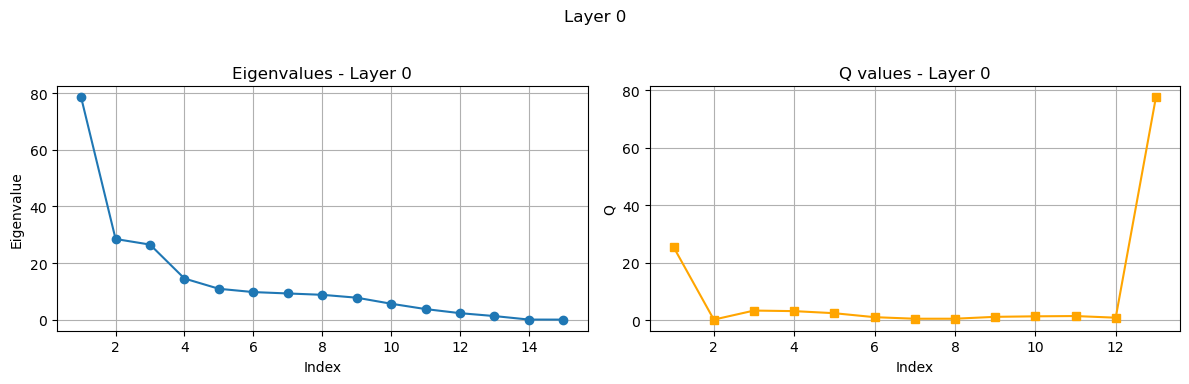

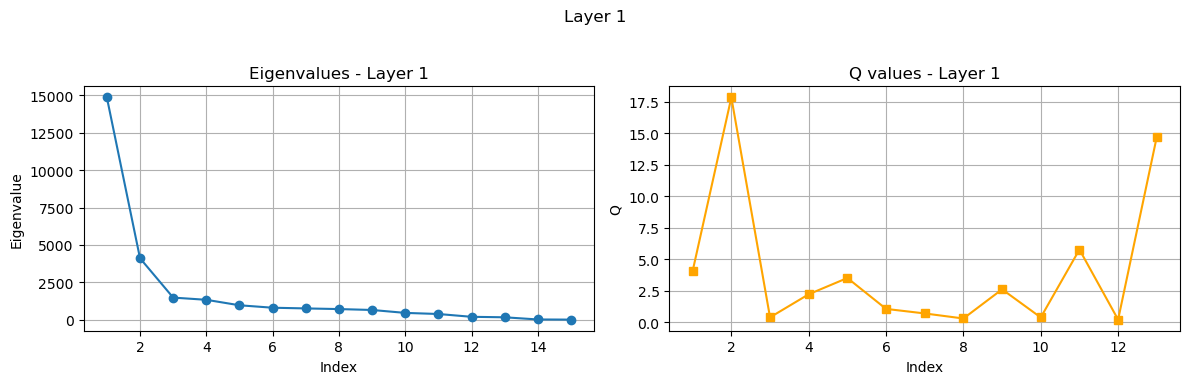

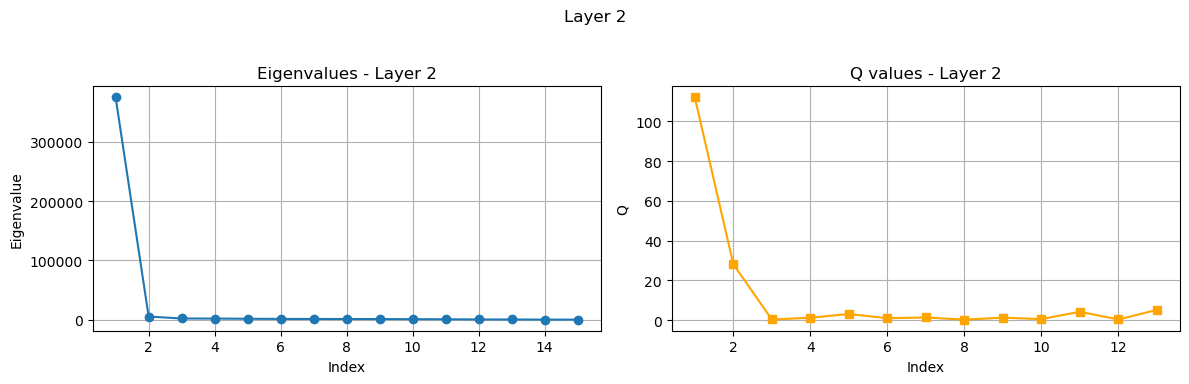

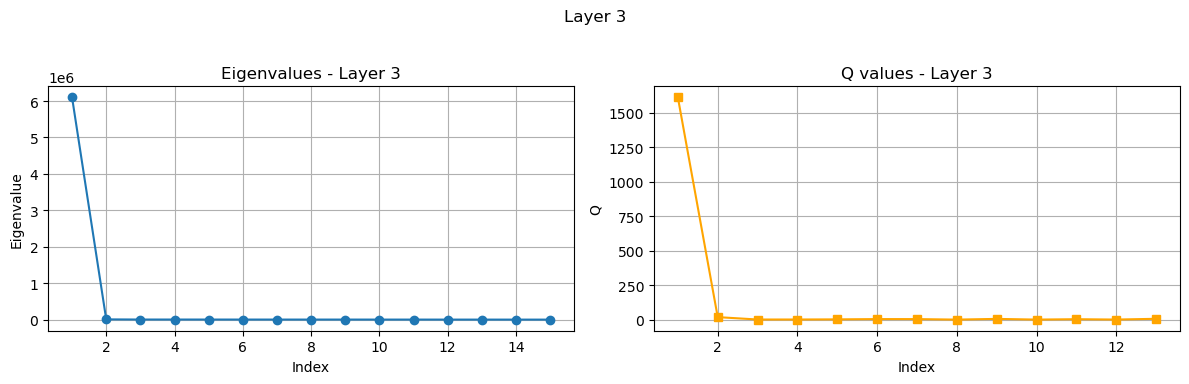

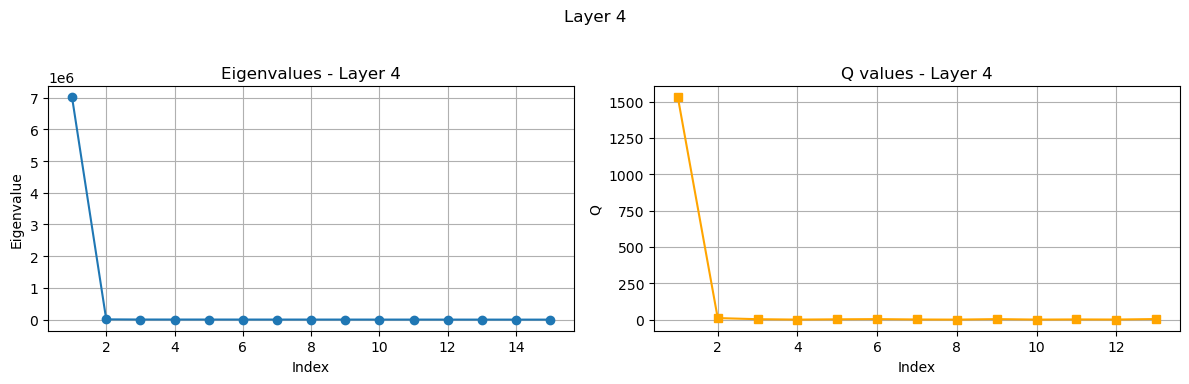

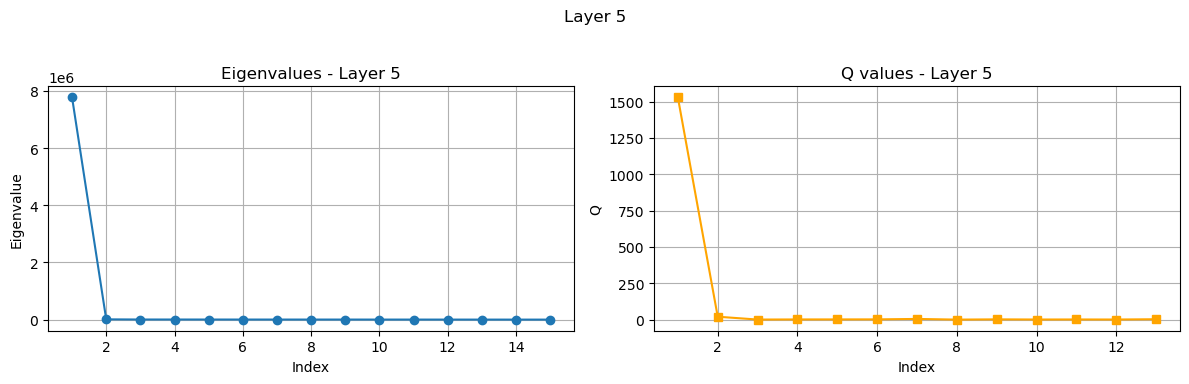

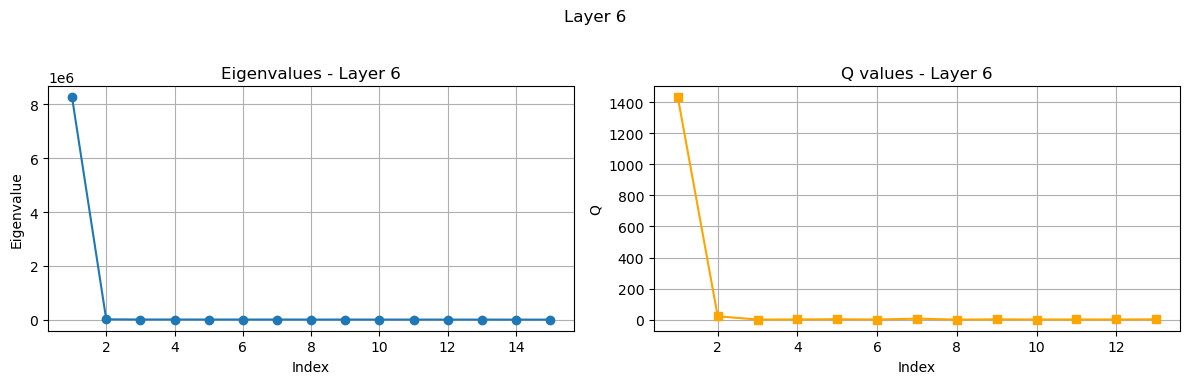

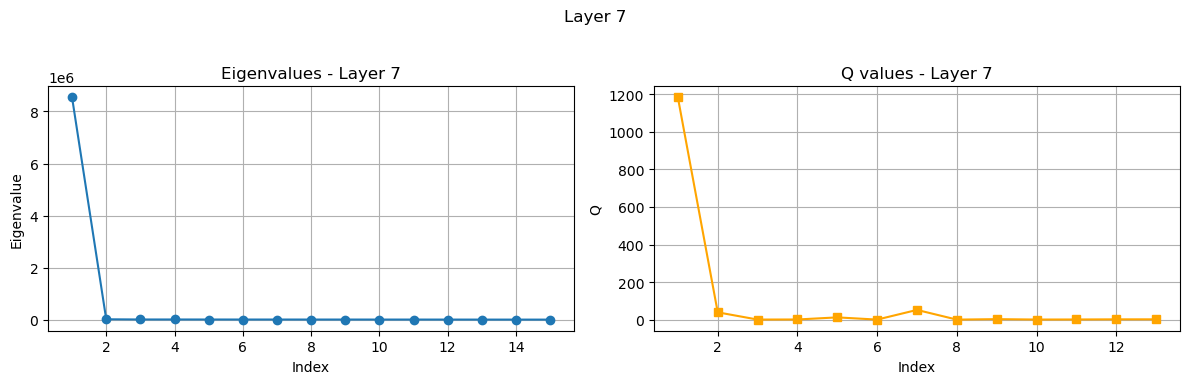

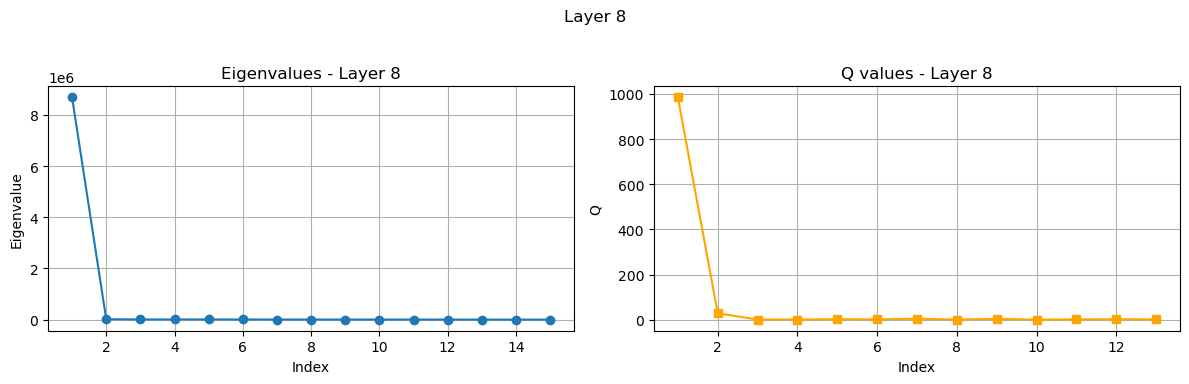

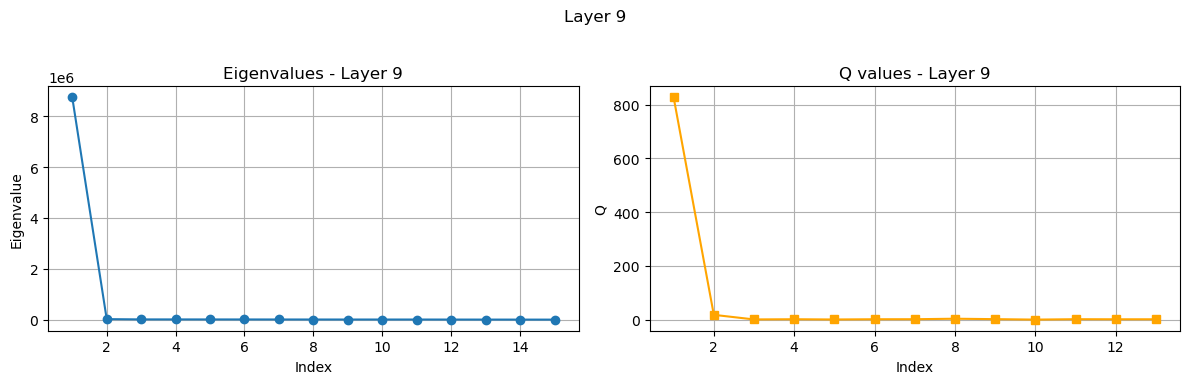

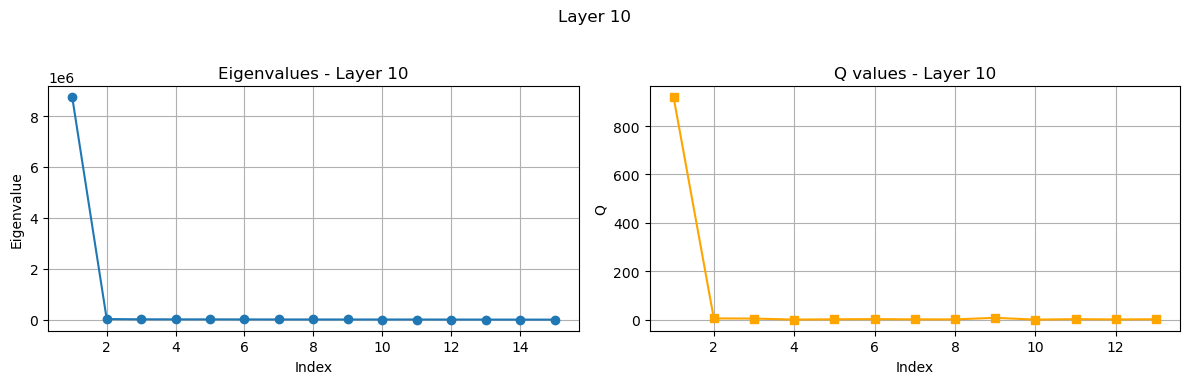

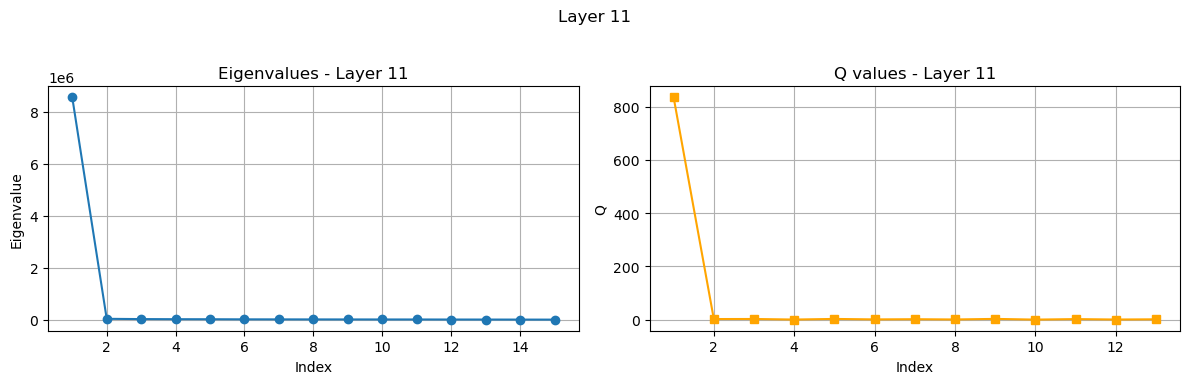

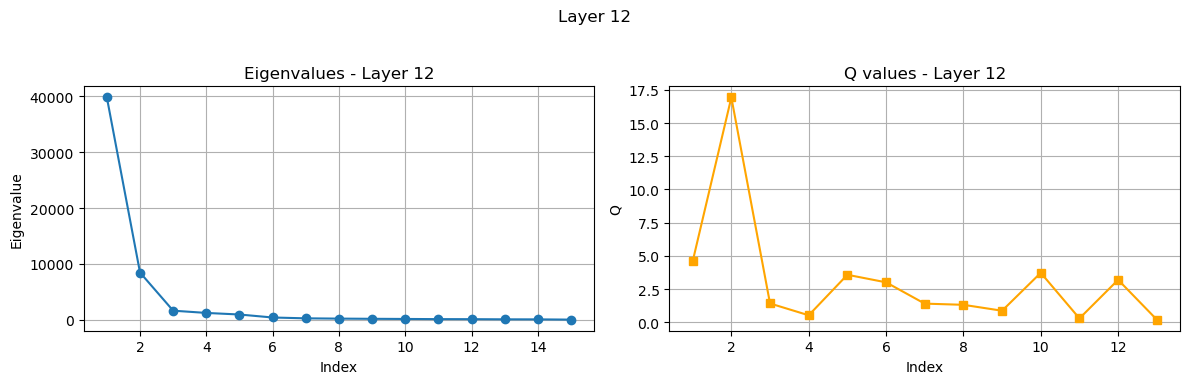

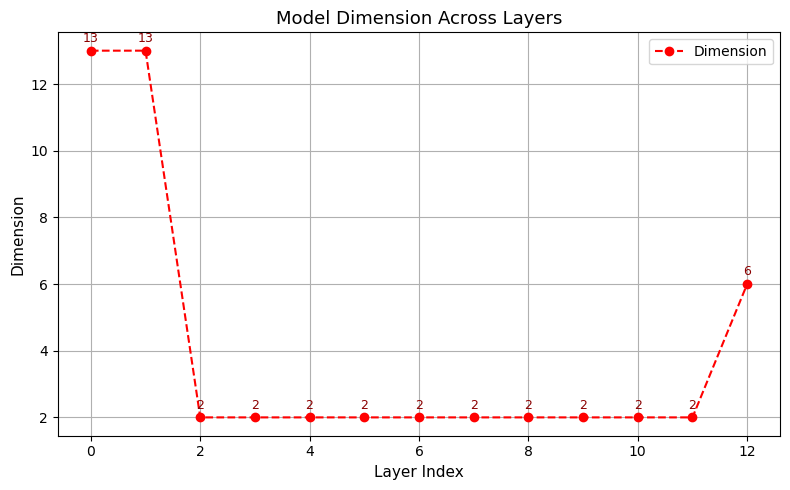

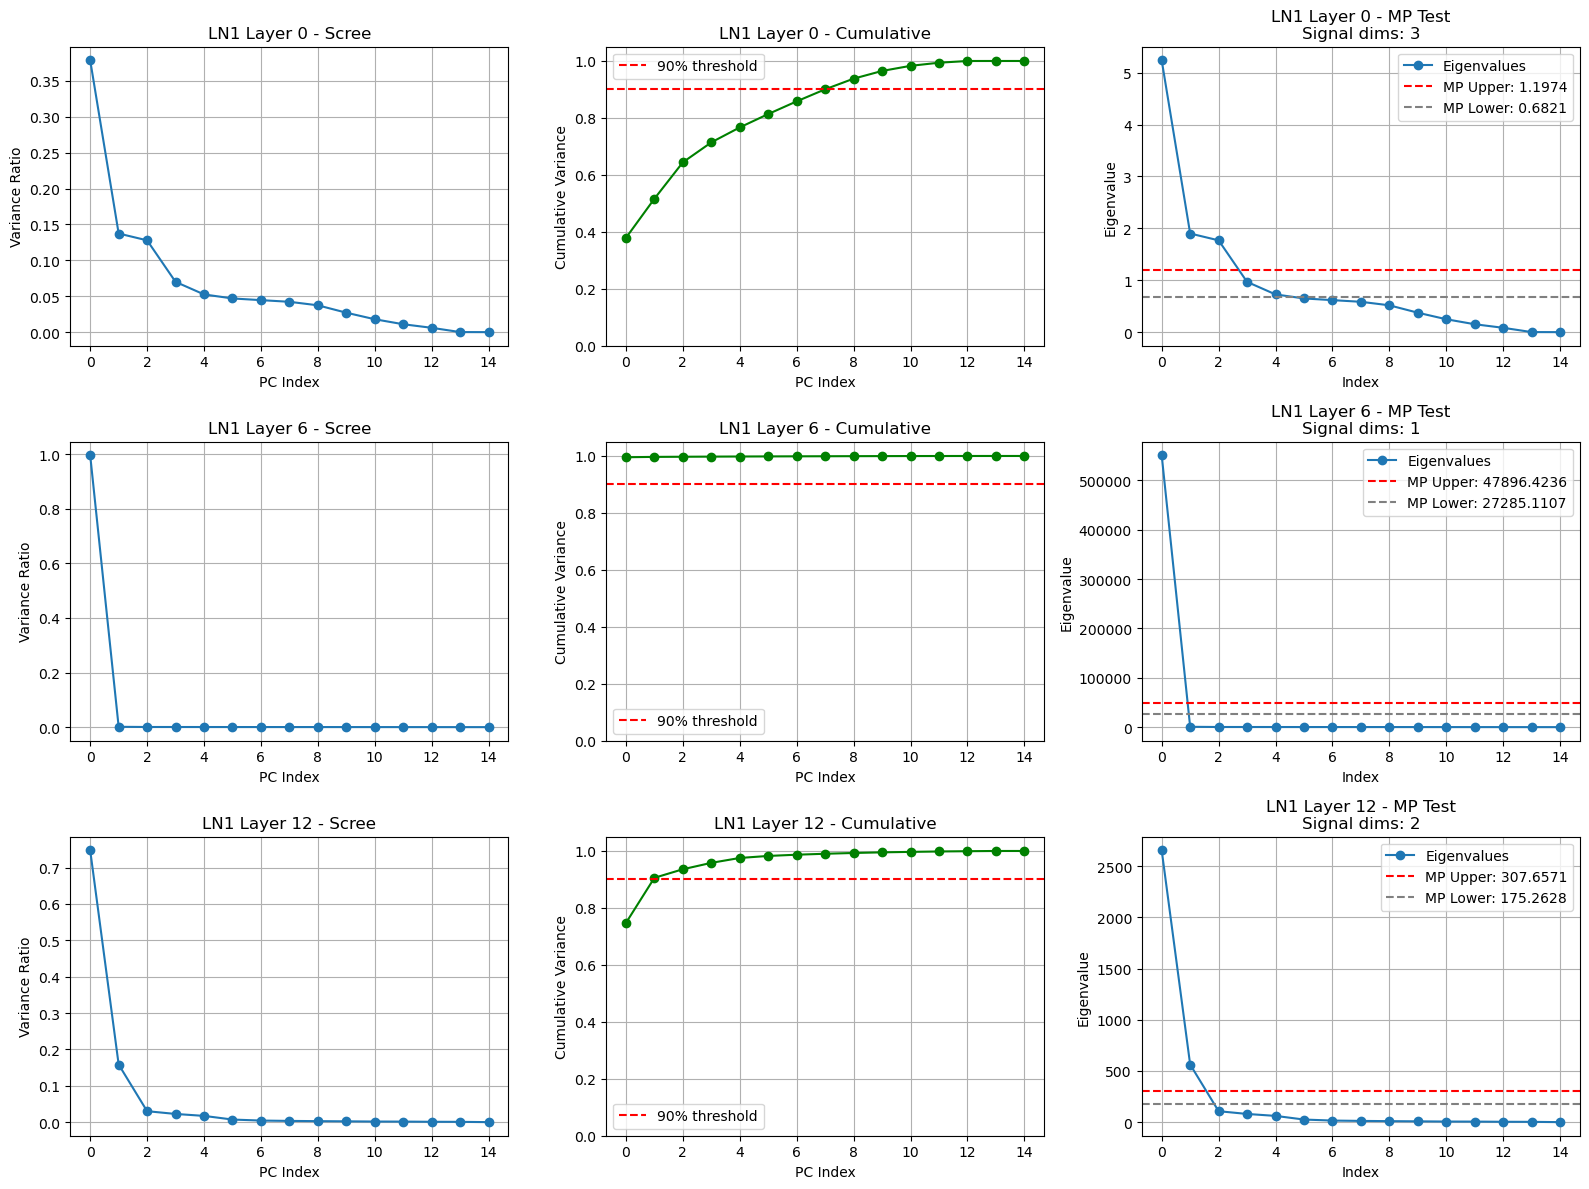

Done the prompt:  1
Done the prompt:  2
Done the prompt:  3
Done the prompt:  4
Done the prompt:  5
Done the prompt:  6
Done the prompt:  7
Done the prompt:  8
Done the prompt:  9
Done the prompt:  10
Done the prompt:  11
Done the prompt:  12
Done the prompt:  13
Done the prompt:  14
Done the prompt:  15


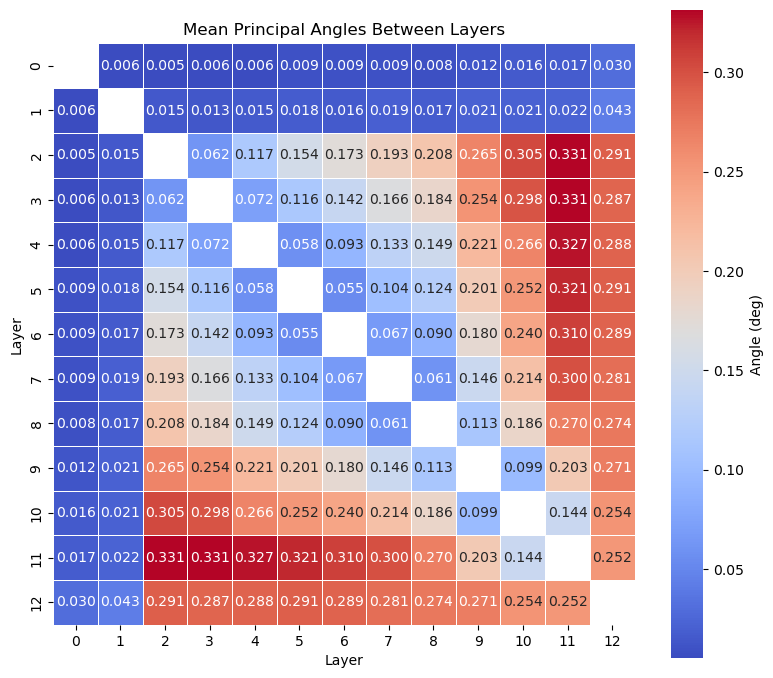

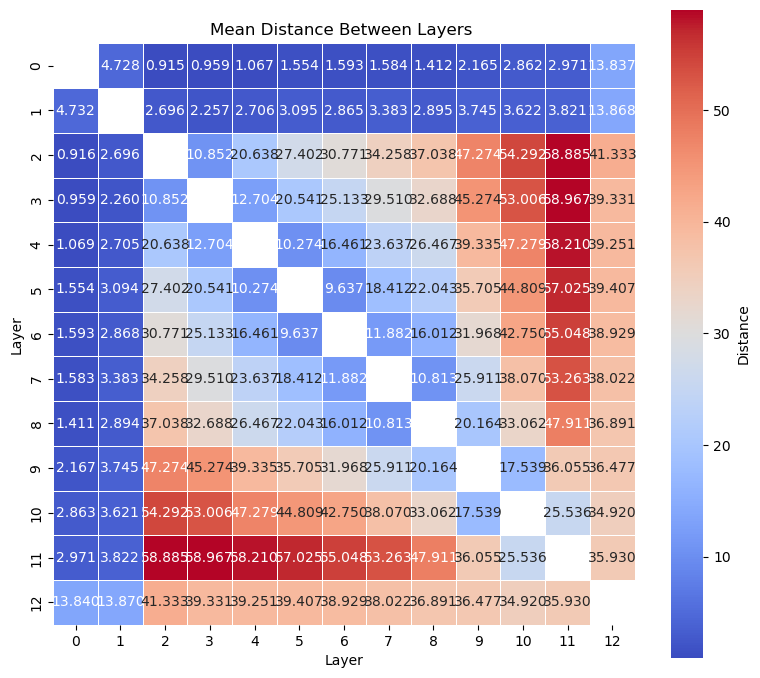

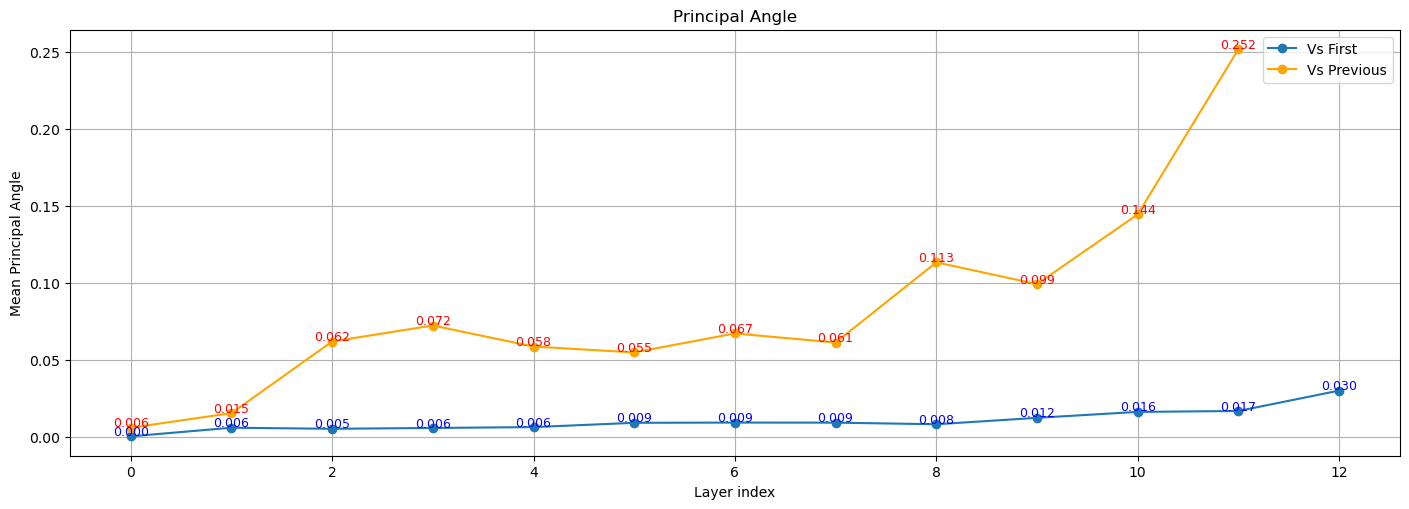

MWMWMWMWMMWMWMWMMWMWMWMWMWMMWMWM
ANALYZING prompt  medium
MWMWMWMWMMWMWMWMMWMWMWMWMWMMWMWM
Done the prompt:  0


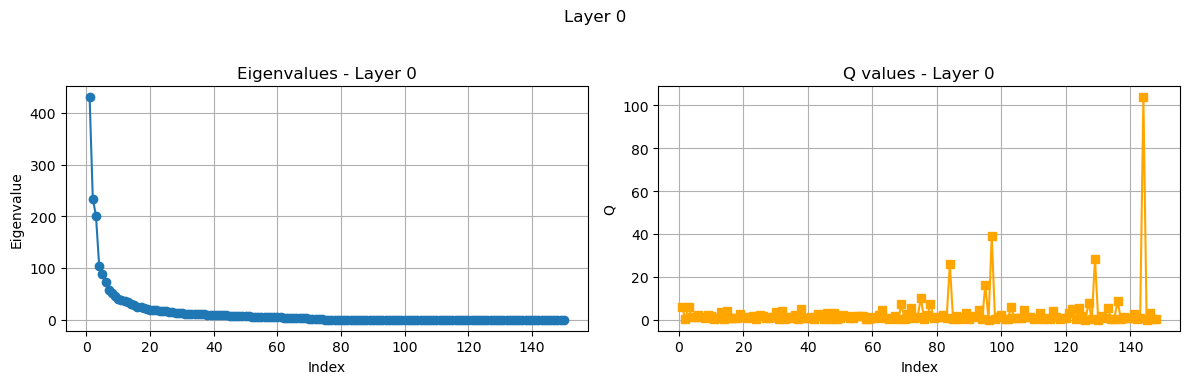

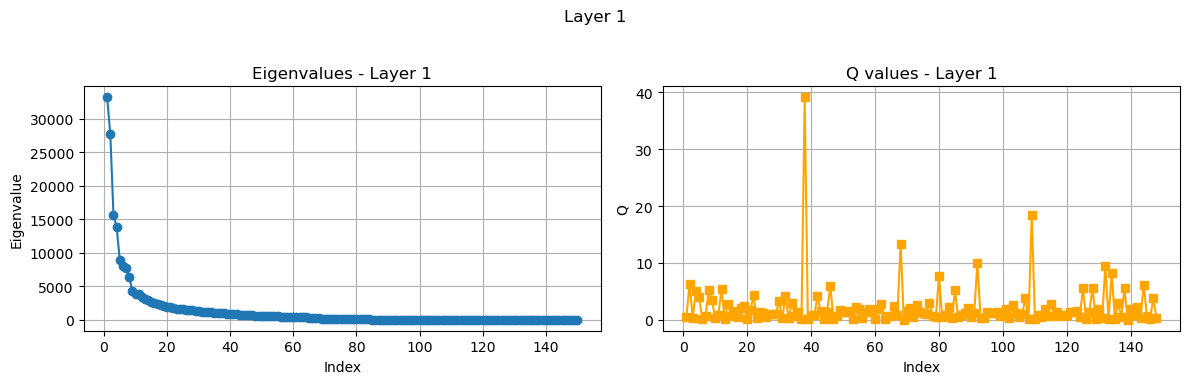

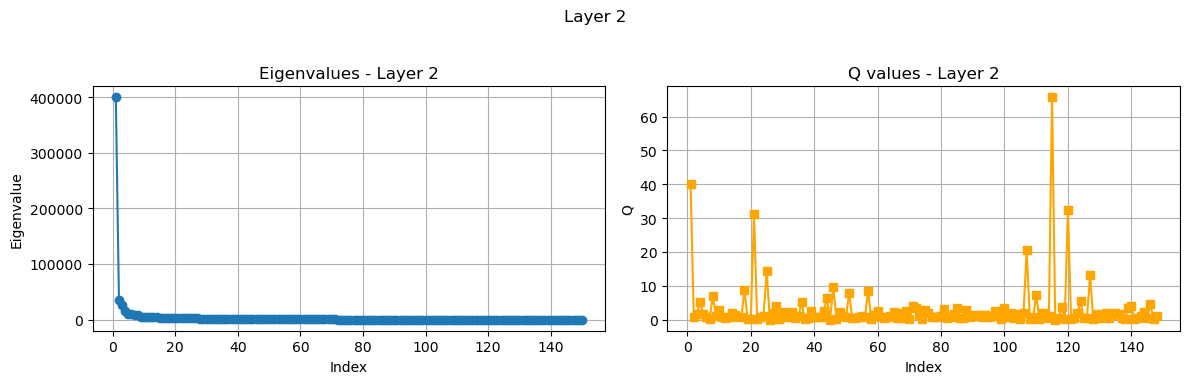

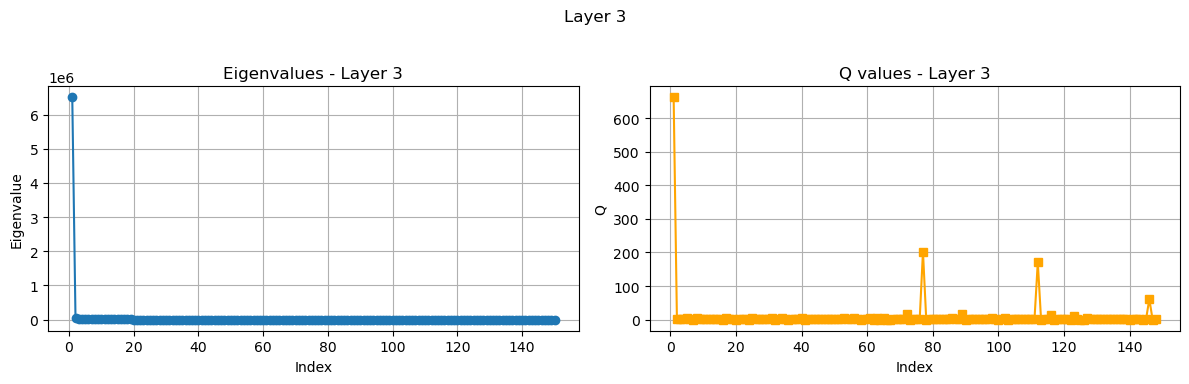

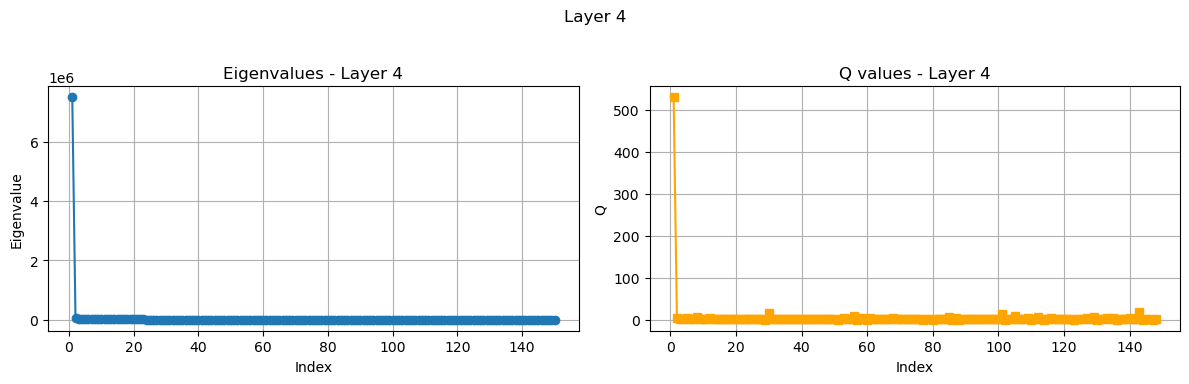

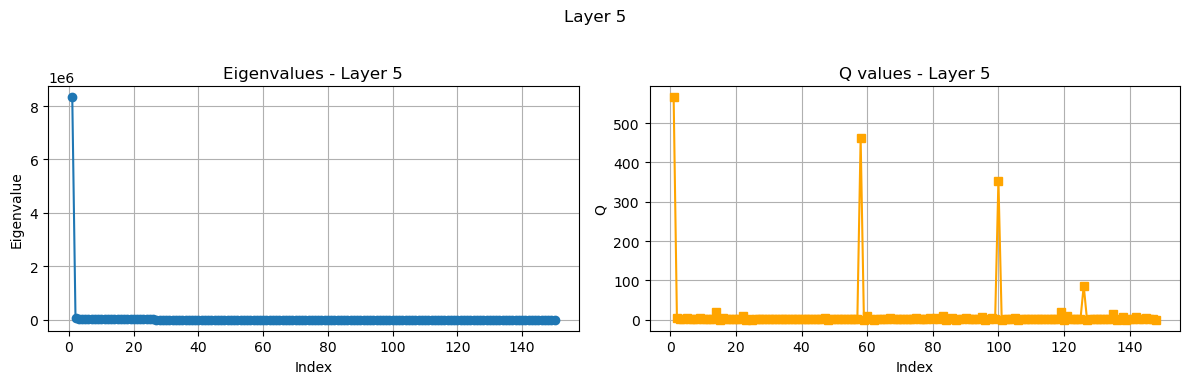

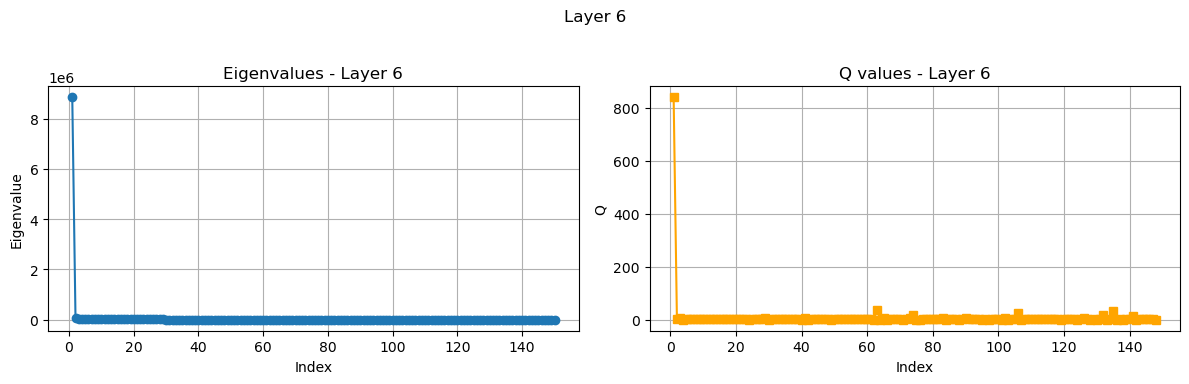

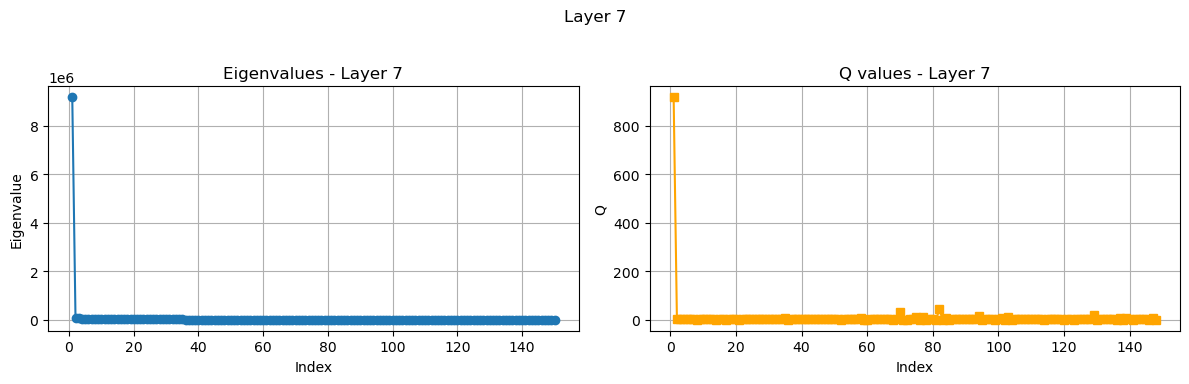

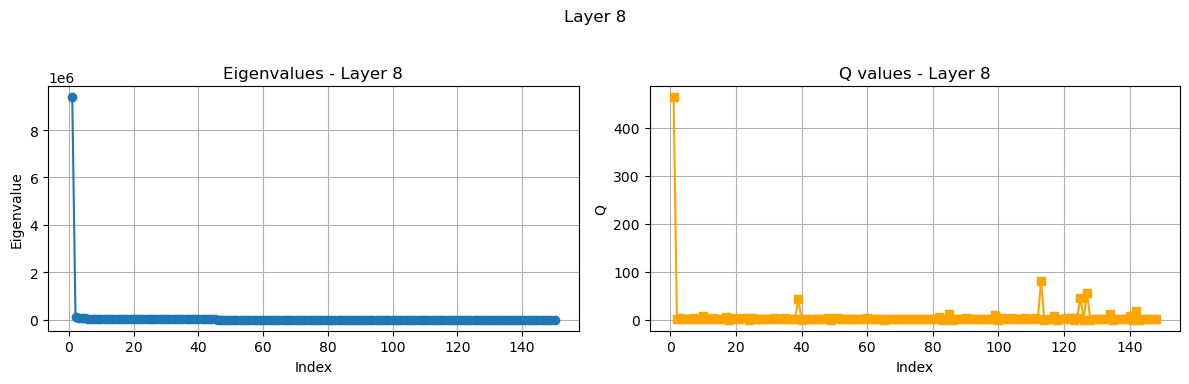

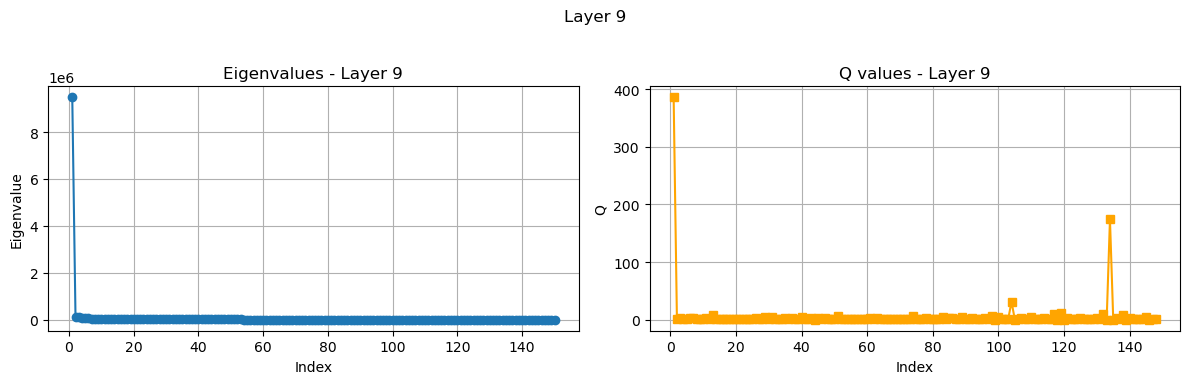

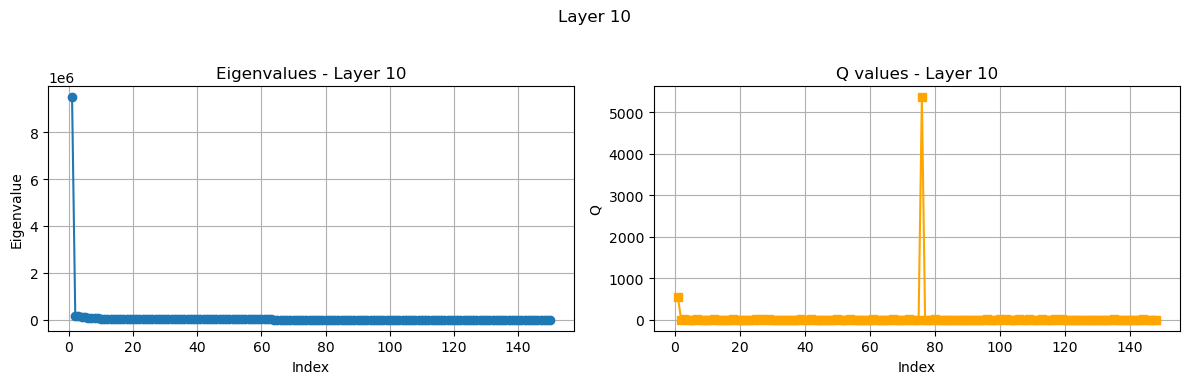

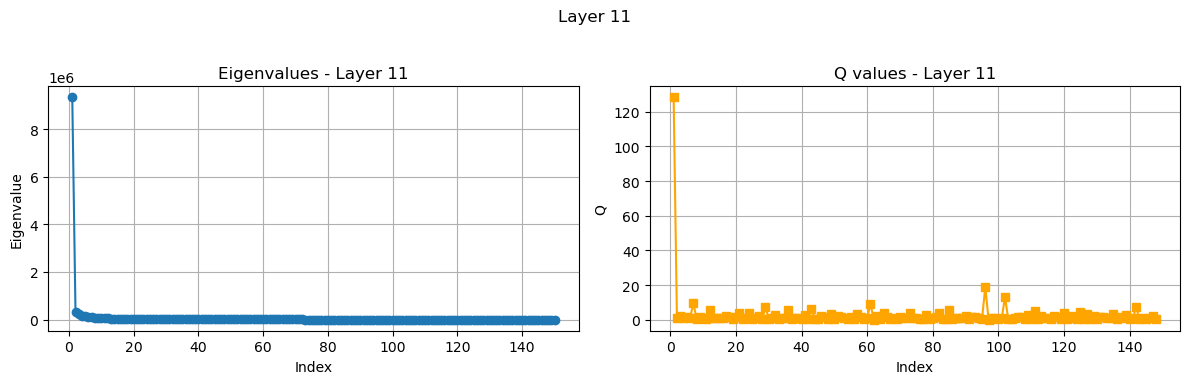

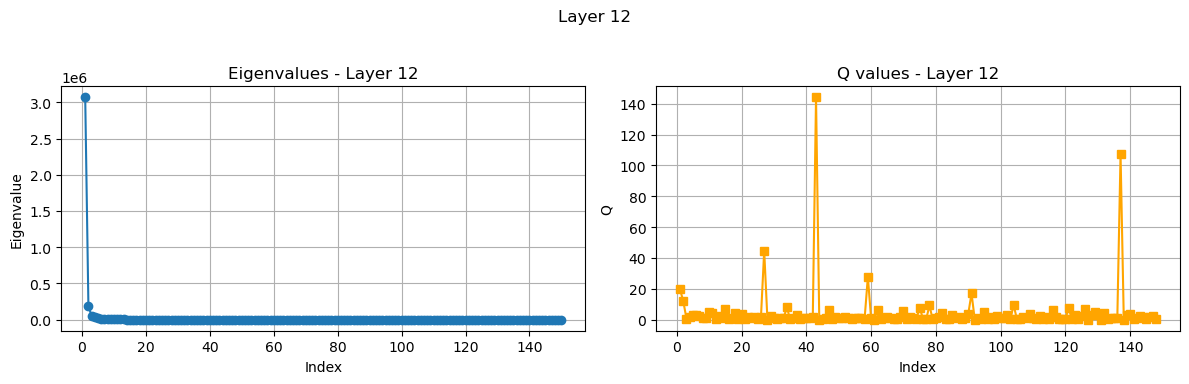

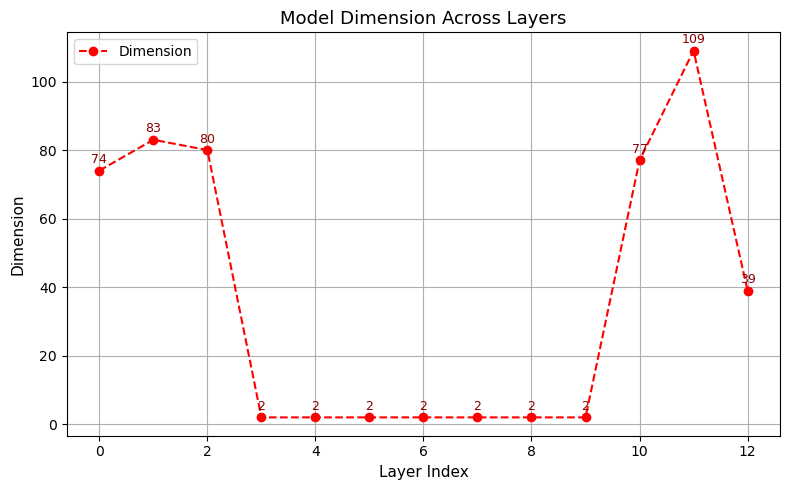

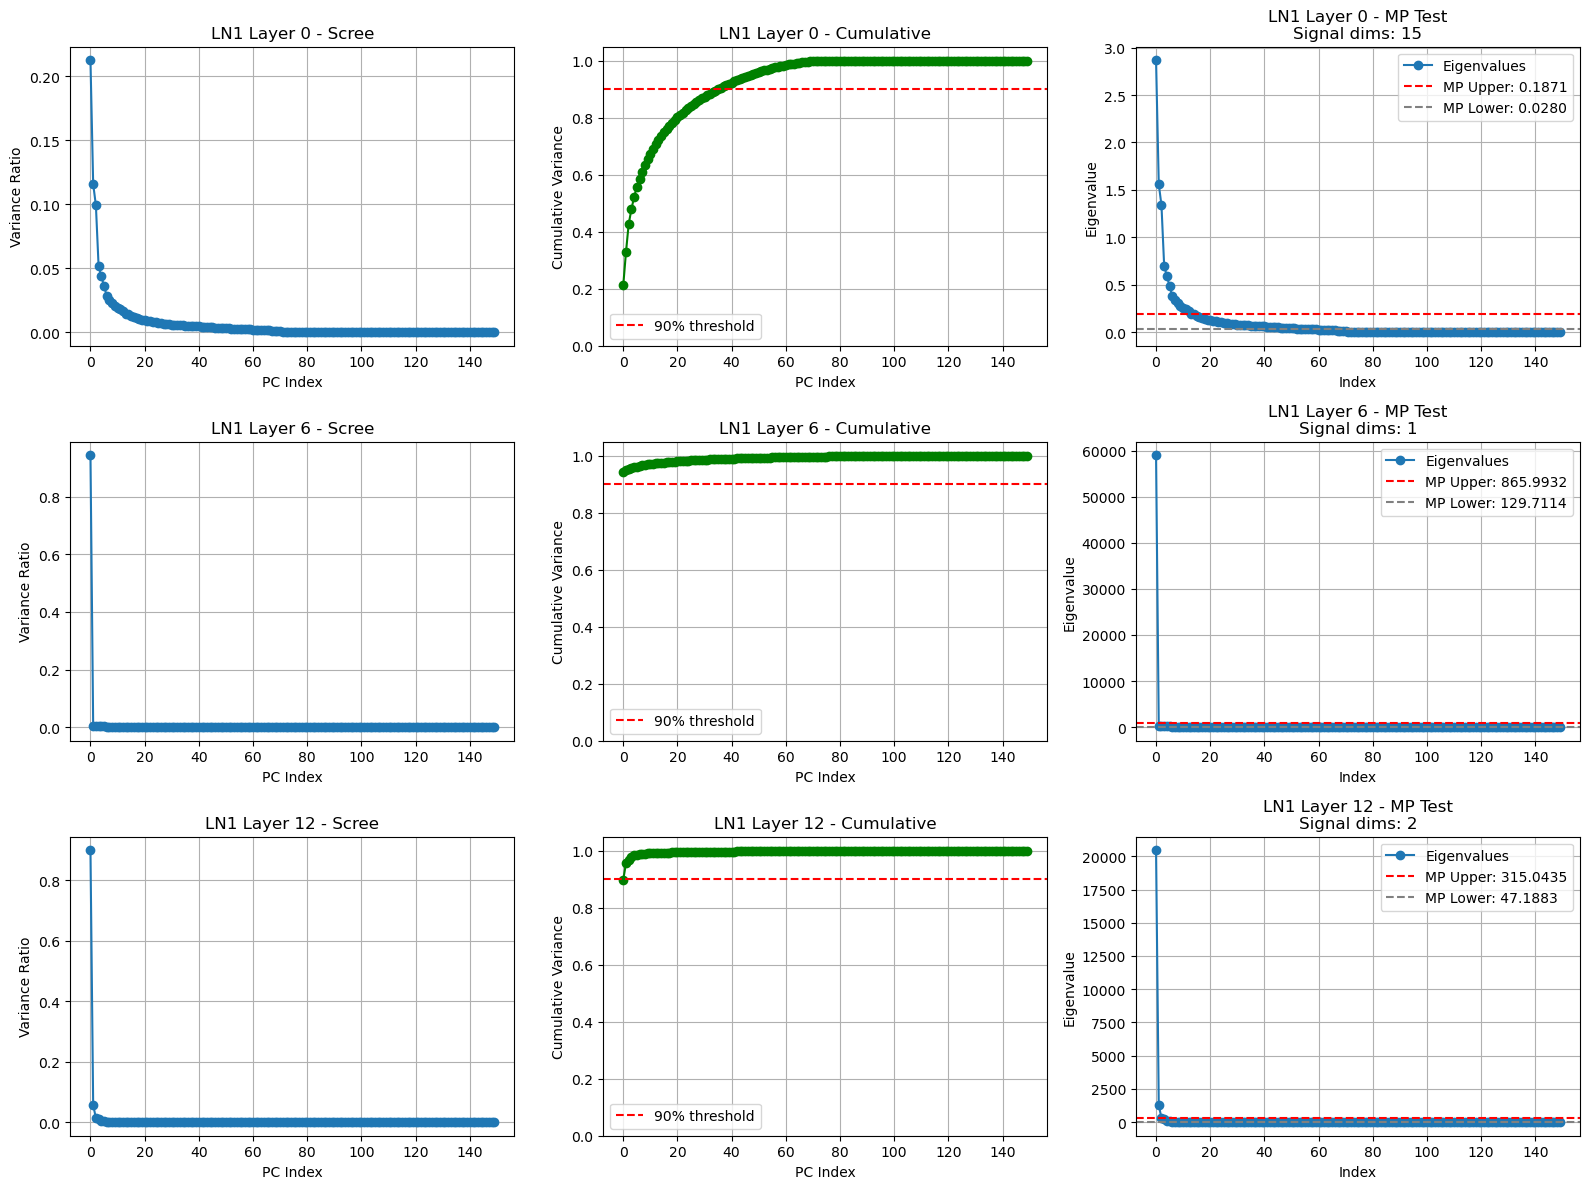

Done the prompt:  1
Done the prompt:  2
Done the prompt:  3
Done the prompt:  4
Done the prompt:  5
Done the prompt:  6
Done the prompt:  7
Done the prompt:  8
Done the prompt:  9
Done the prompt:  10
Done the prompt:  11
Done the prompt:  12
Done the prompt:  13
Done the prompt:  14
Done the prompt:  15


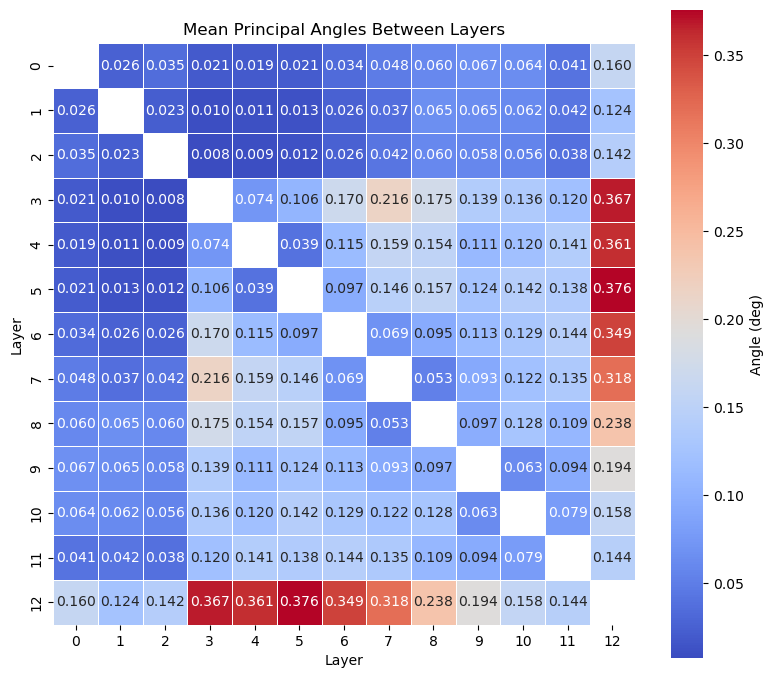

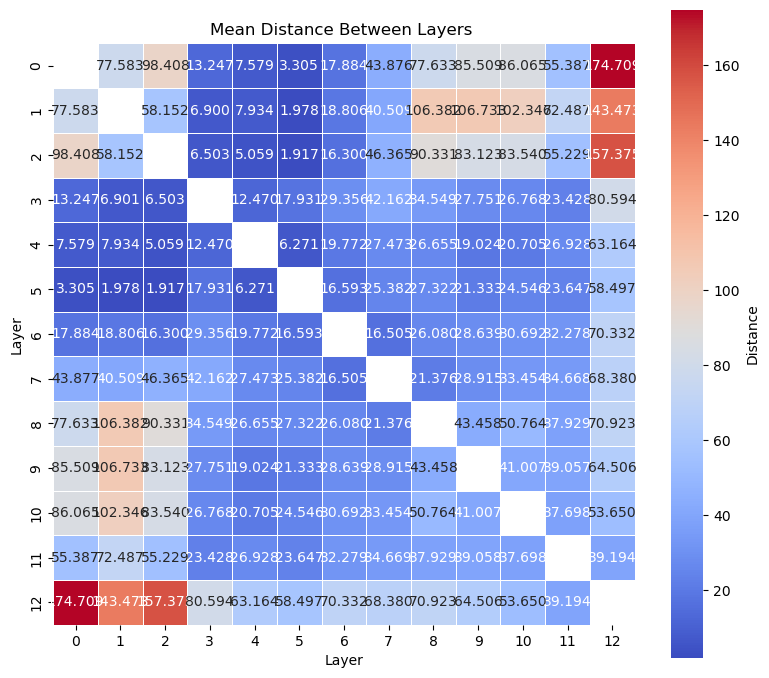

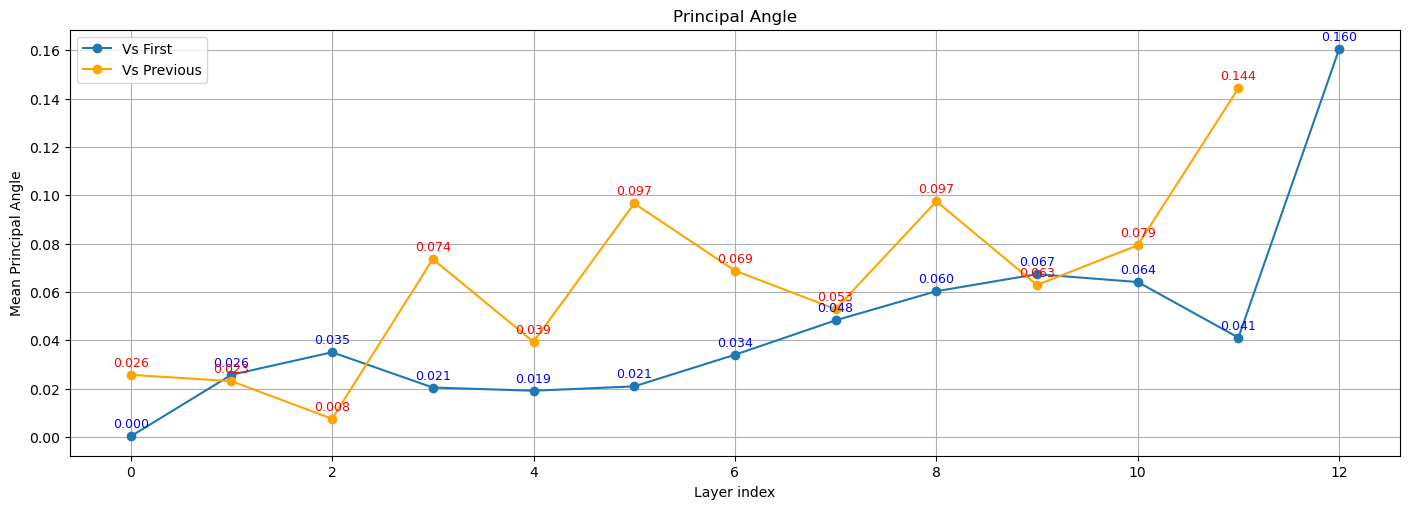

MWMWMWMWMMWMWMWMMWMWMWMWMWMMWMWM
ANALYZING prompt  long
MWMWMWMWMMWMWMWMMWMWMWMWMWMMWMWM
Done the prompt:  0


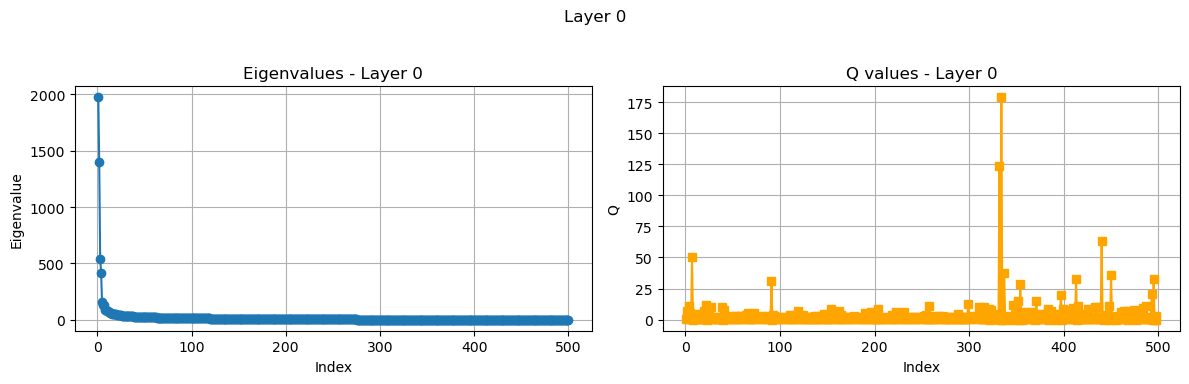

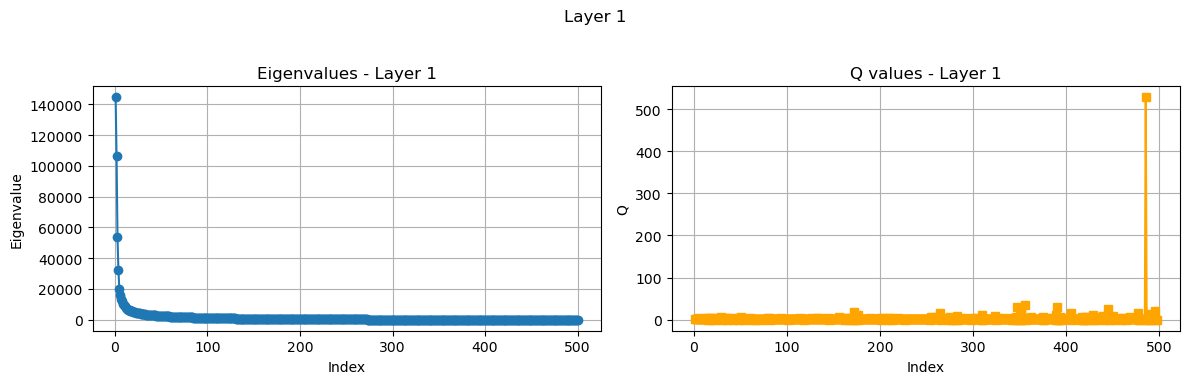

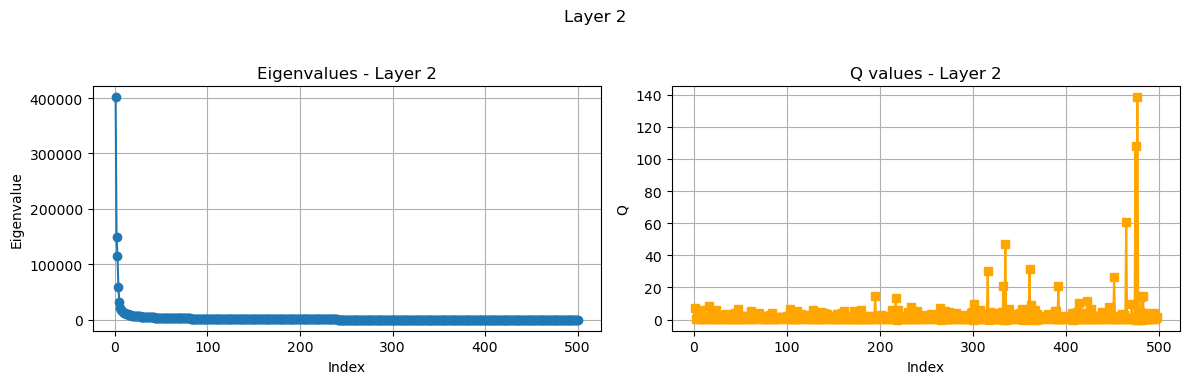

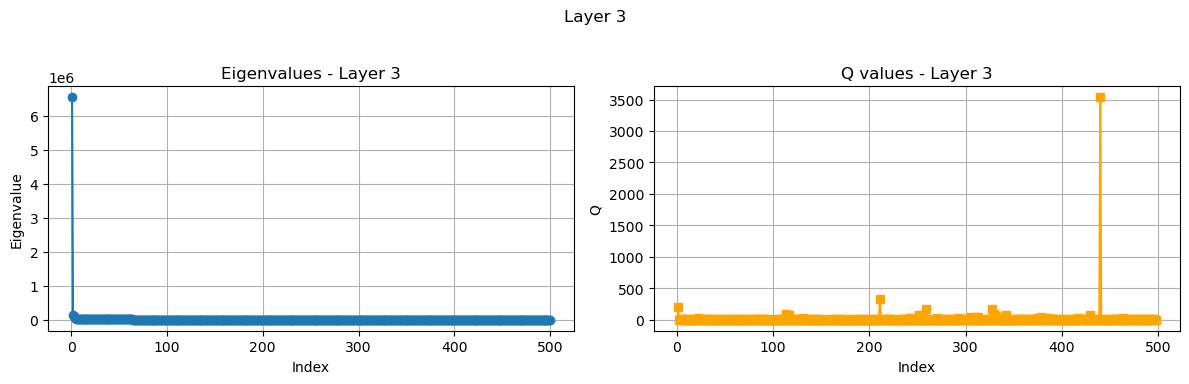

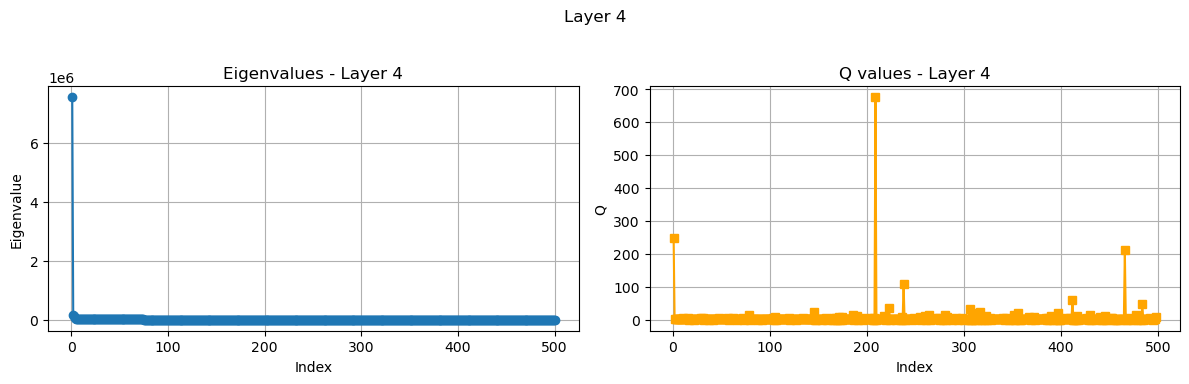

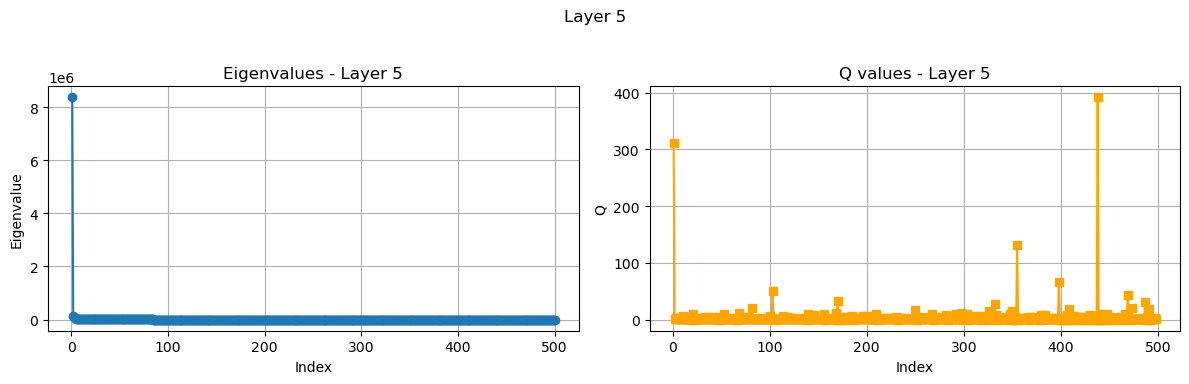

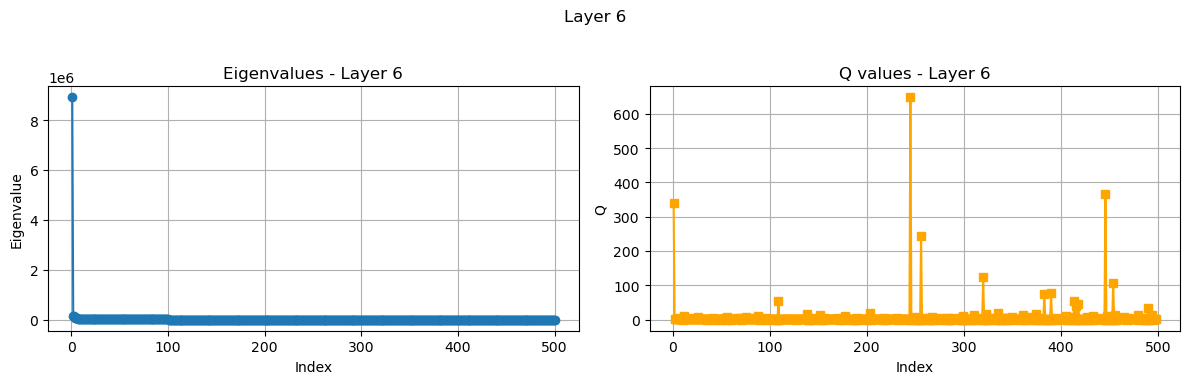

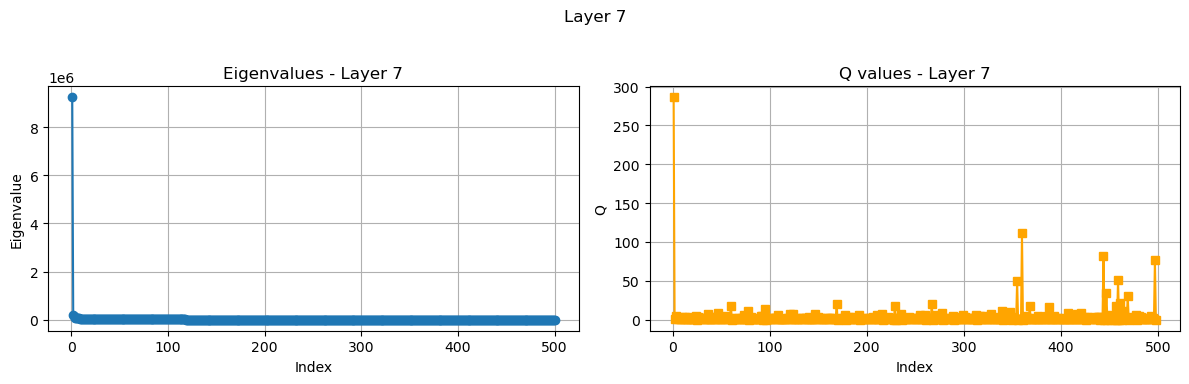

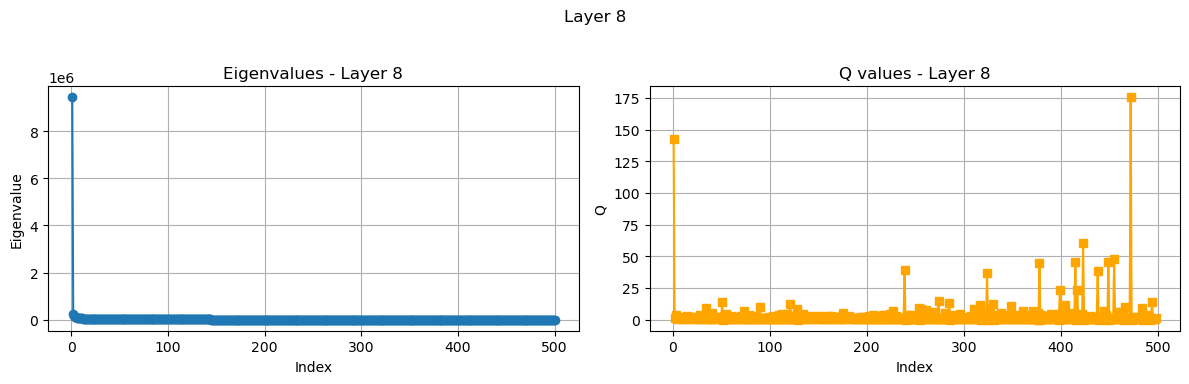

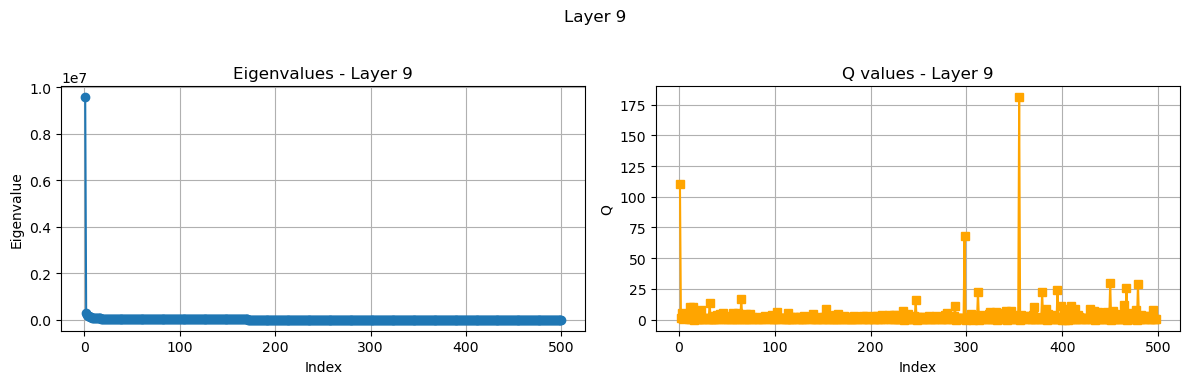

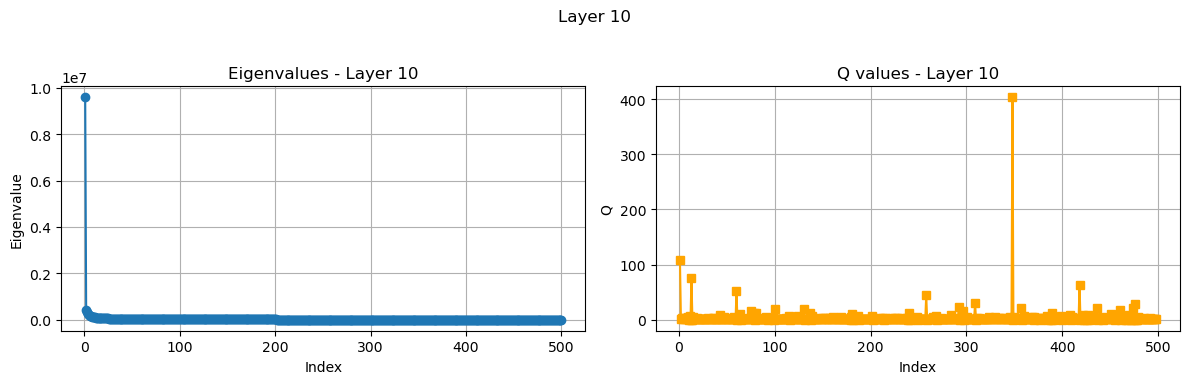

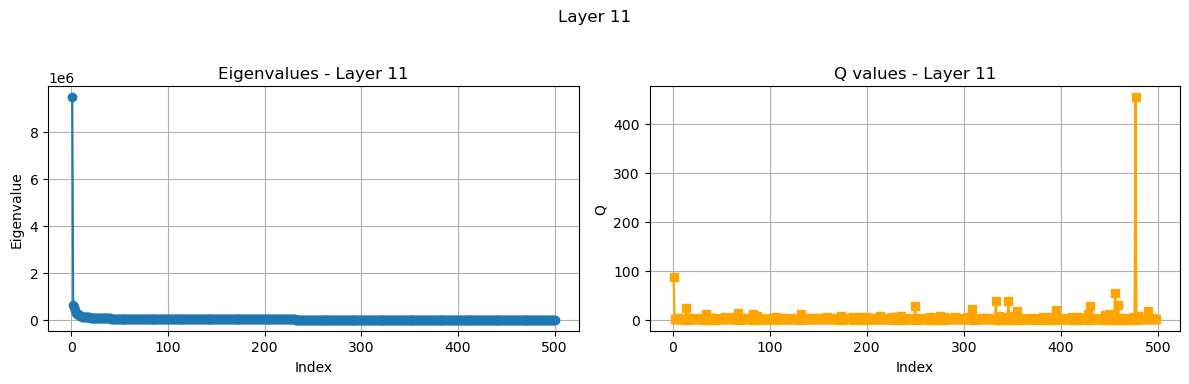

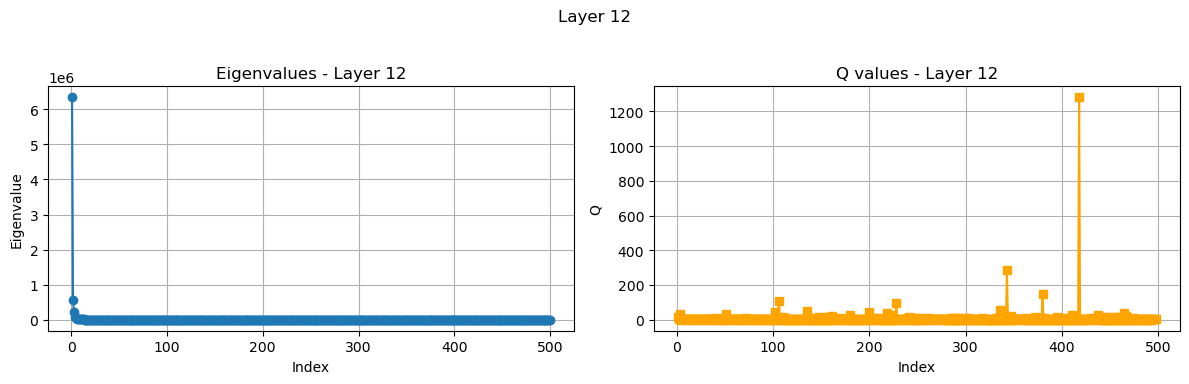

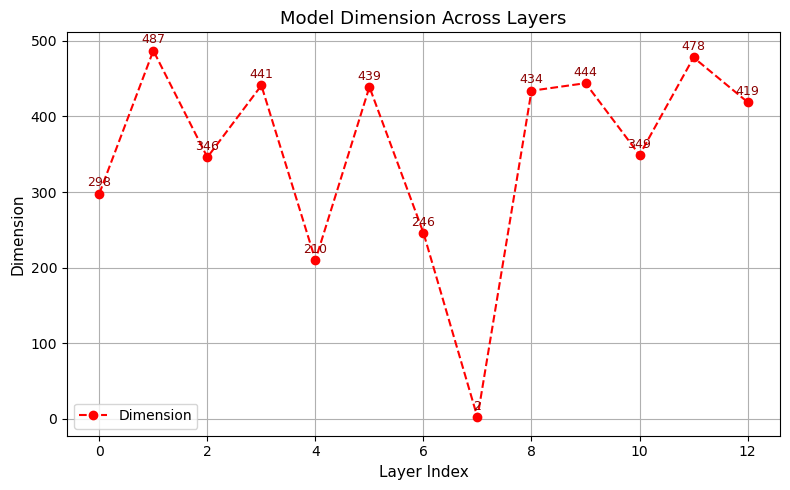

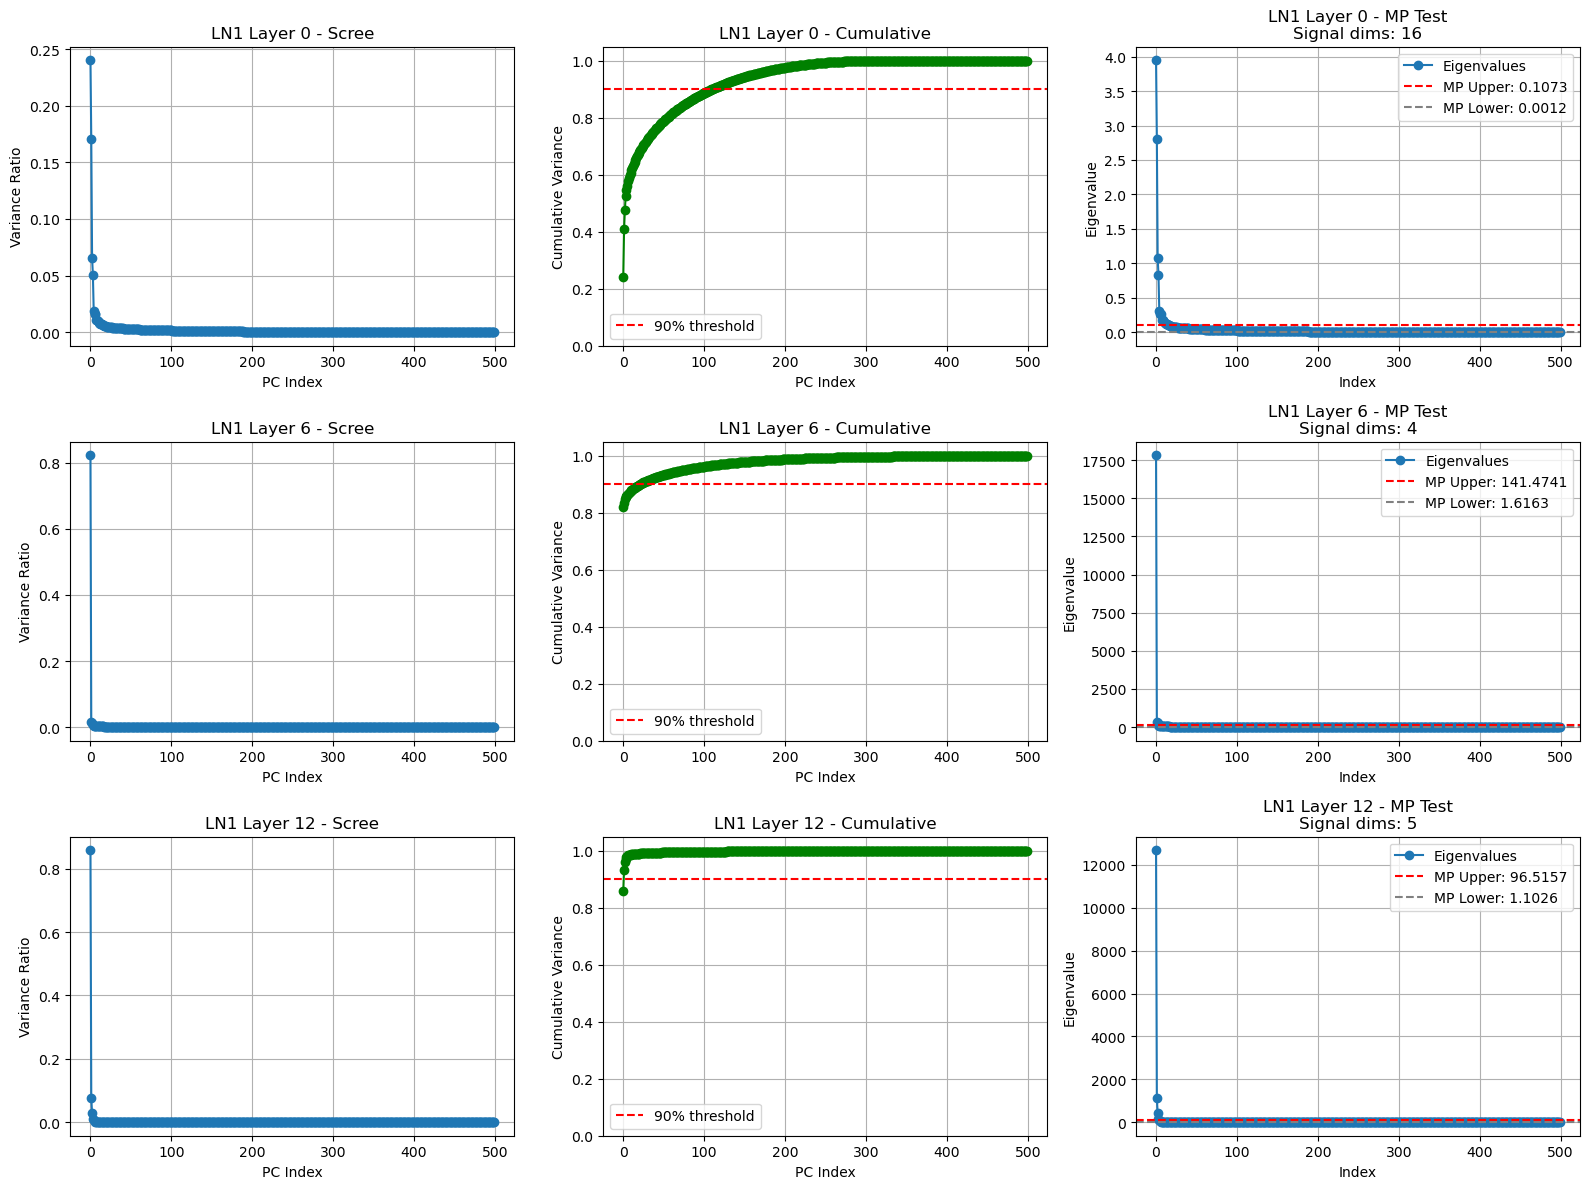

Done the prompt:  1
Done the prompt:  2
Done the prompt:  3
Done the prompt:  4
Done the prompt:  5
Done the prompt:  6
Done the prompt:  7
Done the prompt:  8
Done the prompt:  9
Done the prompt:  10
Done the prompt:  11
Done the prompt:  12
Done the prompt:  13
Done the prompt:  14
Done the prompt:  15


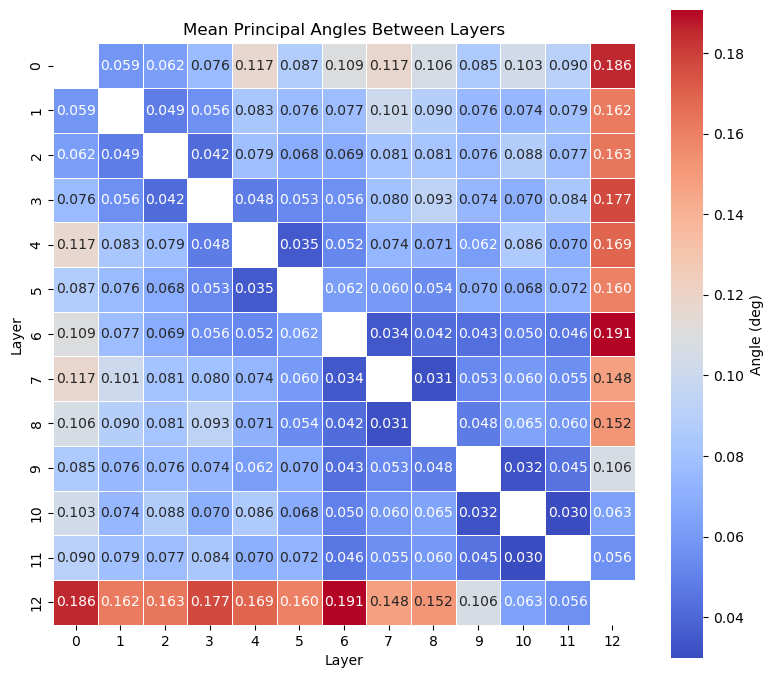

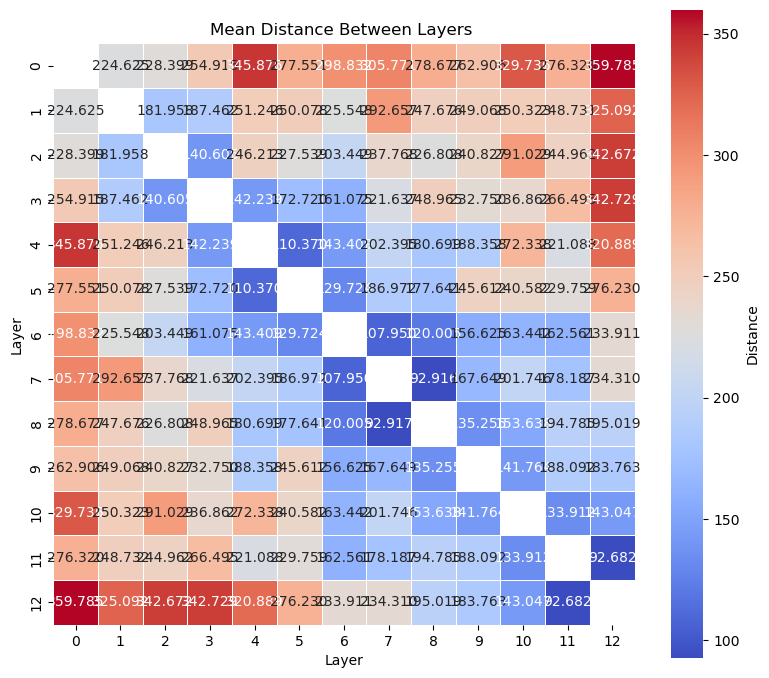

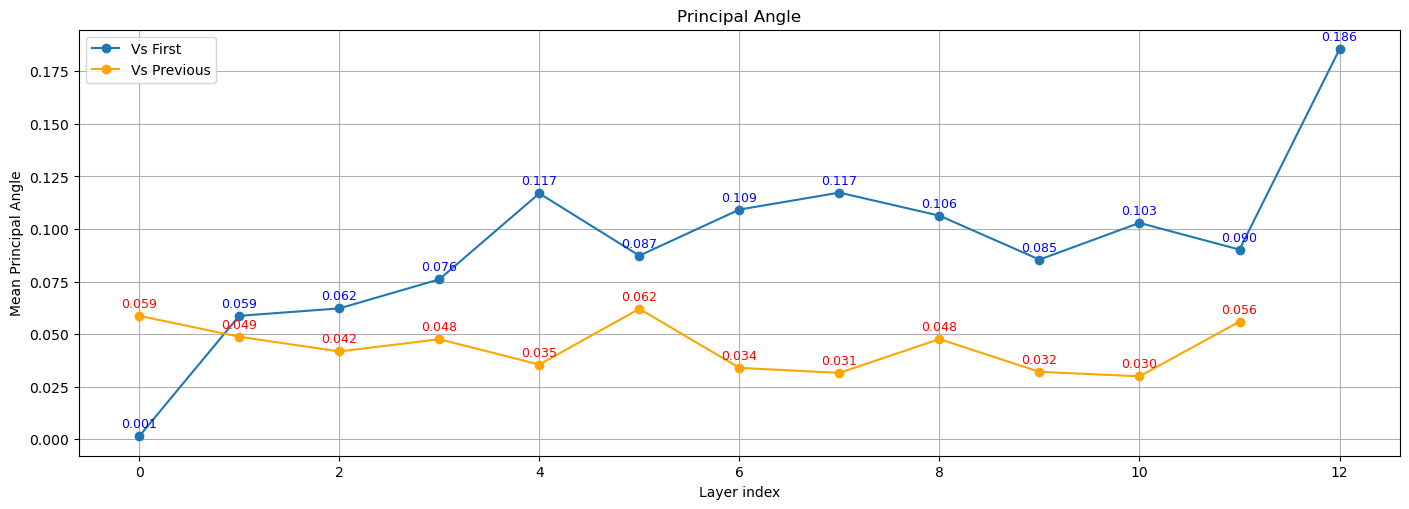

In [10]:

#RESULTS CAN BE DIFFERENT FROM THE PRESENTATION BECAUSE I DID SOME SMALL CHANGES ON CODE

types=["short","medium", "long" ]

prompt_lenght =[15,150,500]  #decide lenght of token

##############  MAIN #################
all_angle=[]
for i, l in enumerate(prompt_lenght):
    
    print("MWMWMWMWMMWMWMWMMWMWMWMWMWMMWMWM")
    print("ANALYZING prompt ", types[i])
    print("MWMWMWMWMMWMWMWMMWMWMWMWMWMMWMWM")

   
    pAngle_all, dist_all, Q_tot = compute_P_angle(prompt, l)

    plot_principle_angle(pAngle_all,dist_all, Q_tot)

 


